In [1]:
# Import widgets for interactive threshold controls
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed
from IPython.display import display
import numpy as np
import spectral as sp
import pandas as pd
from skimage.morphology import remove_small_objects
import matplotlib.pyplot as plt
# import cv2
import math
import os
from sklearn.preprocessing import MinMaxScaler
import copy
import pickle
import warnings
# import seaborn as sns
from Lamewarden_tools.HS_tools.readHS import *
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.pipeline import Pipeline
from scipy.signal import savgol_filter
from sklearn.preprocessing import label_binarize
import datetime
plt.rcParams['axes.grid'] = False
# Ignore RuntimeWarning
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, classification_report
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import accuracy_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler, LabelEncoder
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import optuna
from sklearn.utils import resample
# supplement functions
from imblearn.over_sampling import SMOTE
from scipy.ndimage import gaussian_filter1d
import numpy as np
import copy

import warnings
warnings.filterwarnings("ignore")
import logging
logging.getLogger('spectral').setLevel(logging.CRITICAL)

# Assemblying pre-processing pipeline

In [2]:
import copy
import json
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.ndimage import gaussian_filter1d
from scipy.signal import savgol_filter
from Lamewarden_tools.HS_tools.readHS import HS_image
import warnings
warnings.filterwarnings("ignore")

import copy
import json
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from skimage.morphology import remove_small_objects

class HS_preprocessor:
    """
    Enhanced hyperspectral image preprocessing pipeline with integrated mask extraction.
    
    Features:
    - All original HS_preprocessor functionality preserved
    - Integrated mask extraction using vegetation indices (NDVI, HBSI, PRI)
    - Configurable segmentation parameters stored in config file
    - Mask storage as hs_image.mask attribute
    - Updated run_full_pipeline with mask extraction as final step
    - Updated process_folder with mask integration
    
    Processing Pipeline:
    1. Sensor calibration (white/dark reference correction)
    2. Solar spectrum correction (using reference teflon)  
    3. Spectral smoothing (Gaussian filtering)
    4. Normalization (wavelength-based or SNV)
    5. Mask extraction (vegetation index segmentation) [NEW]
    
    Features:
    - Step-by-step processing with configuration storage
    - Visualization tools for each step
    - Step-by-step testing and visualization
    - Save/load configurations 
    - Folder processing
    - Verbose control for all print outputs
    - Reference teflon spectrum storage and persistence
    - Integrated mask extraction with configurable parameters
    """
    
    def __init__(self, image_path=None, verbose=True):
        """Initialize with optional image path and verbose control."""
        self.image_path = image_path
        self.image = None
        self.original_image = None
        self.white_calibration = None
        self.verbose = verbose
        self.reference_teflon = None  # Store reference teflon data as dict: {wavelength: reflectance}
        
        # Store parameters for each step
        self.config = {}
        self.step_results = {}  # Store intermediate results for visualization
        
        if image_path:
            self.load_image(image_path)
    
    def load_image(self, image_path):
        """Step 1: Load hyperspectral image."""
        self.image_path = image_path
        self.image = HS_image(image_path)
        self.original_image = copy.deepcopy(self.image)
        if self.verbose:
            print(f"✓ Loaded image: {os.path.basename(image_path)}")
            print(f"  Shape: {self.image.img.shape}")
            print(f"  Wavelength range: {min(self.image.ind)}-{max(self.image.ind)} nm")
        return self
    
    def _upload_calibration(self, dark_calibration=None, white_ref_path=None):
        """Upload white and dark calibration matrices."""
        if white_ref_path:
            # Use external white reference
            white_calibration = HS_image(white_ref_path)
            white_matrix = np.mean(white_calibration.img, axis=0)

        
        if dark_calibration:
            # Use image edges as dark reference
            dark_calib = HS_image(dark_calibration)  
            dark_matrix = np.mean(dark_calib.img, axis=0)
        else:
            # Use image edges as dark reference
            dark_matrix = np.zeros(white_matrix.shape)

                
        return white_matrix, dark_matrix
    

    
    # def solar_correction(self, teflon_edge_coord=(-10, -3), reference_teflon=None, smooth_window=35):
    #     """Step 3: Correct for solar illumination using teflon panel."""
    #     # Store parameters for this step
    #     self.config['solar_correction'] = {
    #         'teflon_edge_coord': teflon_edge_coord,
    #         'smooth_window': smooth_window,
    #         'reference_teflon': reference_teflon.tolist() if reference_teflon is not None else None,
    #         'reference_source': 'provided' if reference_teflon is not None else 'auto',
    #         'has_reference': reference_teflon is not None
    #     }
        
    #     # Extract teflon spectrum from image edge
    #     teflon_start, teflon_end = teflon_edge_coord
    #     teflon_spectrum = self.image.img[:, teflon_start:teflon_end, :].mean(axis=(0, 1))
        
    #     # Smooth the teflon spectrum
    #     teflon_spectrum_smooth = gaussian_filter1d(teflon_spectrum, sigma=smooth_window//2)
        
    #     # Use reference teflon if provided, otherwise use extracted spectrum
    #     if reference_teflon is not None:
    #         reference_spectrum = np.array(reference_teflon)
    #         # Smooth reference spectrum too
    #         reference_spectrum_smooth = gaussian_filter1d(reference_spectrum, sigma=smooth_window//2)
    #     else:
    #         reference_spectrum_smooth = teflon_spectrum_smooth
        
    #     # Calculate correction factor (avoid division by zero)
    #     correction_factor = reference_spectrum_smooth / (teflon_spectrum_smooth + 1e-7)
        
    #     # Apply correction to entire image
    #     corrected_img = self.image.img * correction_factor[np.newaxis, np.newaxis, :]
        
    #     # Update image
    #     self.image.img = corrected_img
    #     self.step_results['solar_correction'] = copy.deepcopy(self.image)
        
    #     if self.verbose:
    #         print(f"✓ Solar correction completed")
    #         print(f"  Teflon coordinates: {teflon_edge_coord}")
    #         print(f"  Smoothing window: {smooth_window}")
    #         print(f"  Reference: {'Provided' if reference_teflon is not None else 'Auto-extracted'}")
        
    #     return self
    
    # def spectral_smoothing(self, sigma=11, mode='reflect'):
    #     """Step 4: Apply spectral smoothing using Gaussian filter."""
    #     # Store parameters for this step
    #     self.config['spectral_smoothing'] = {
    #         'sigma': sigma,
    #         'mode': mode
    #     }
        
    #     # Apply Gaussian smoothing along spectral dimension
    #     smoothed_img = gaussian_filter1d(self.image.img, sigma=sigma, axis=2, mode=mode)
        
    #     # Update image
    #     self.image.img = smoothed_img
    #     self.step_results['spectral_smoothing'] = copy.deepcopy(self.image)
        
    #     if self.verbose:
    #         print(f"✓ Spectral smoothing completed")
    #         print(f"  Sigma: {sigma}")
    #         print(f"  Mode: {mode}")
        
    #     return self
    
    # def normalization(self, method='to_wl', to_wl=751, clip_to=10):
    #     """Step 5: Normalize the image using specified method."""
    #     # Store parameters for this step
    #     self.config['normalization'] = {
    #         'method': method,
    #         'to_wl': to_wl,
    #         'clip_to': clip_to
    #     }
        
    #     if method == 'to_wl':
    #         # Find the closest wavelength index
    #         wl_idx = np.argmin(np.abs(np.array(self.image.ind) - to_wl))
            
    #         # Normalize to specified wavelength
    #         normalization_band = self.image.img[:, :, wl_idx:wl_idx+1]
    #         normalized_img = self.image.img / (normalization_band + 1e-7)
            
    #         # Clip extreme values
    #         normalized_img = np.clip(normalized_img, 0, clip_to)
            
    #     elif method == 'snv':
    #         # Standard Normal Variate normalization
    #         # SNV = (spectrum - mean) / std for each pixel
    #         mean_spectrum = np.mean(self.image.img, axis=2, keepdims=True)
    #         std_spectrum = np.std(self.image.img, axis=2, keepdims=True)
    #         normalized_img = (self.image.img - mean_spectrum) / (std_spectrum + 1e-7)
        
    #     else:
    #         raise ValueError(f"Unknown normalization method: {method}")
        
    #     # Update image
    #     self.image.img = normalized_img
    #     self.step_results['normalization'] = copy.deepcopy(self.image)
        
    #     if self.verbose:
    #         print(f"✓ Normalization completed")
    #         print(f"  Method: {method}")
    #         if method == 'to_wl':
    #             actual_wl = self.image.ind[wl_idx]
    #             print(f"  Target wavelength: {to_wl} nm (actual: {actual_wl} nm)")
    #             print(f"  Clipped to: {clip_to}")
        
    #     return self
    
    def extract_masks(self, pri_thr=None, ndvi_thr=None, hbsi_thr=None, min_pix_size=None, 
                     repeat=10, show_visualization=True):
        """Step 6: Extract vegetation masks using vegetation indices."""
        
        # Use parameters from loaded config if available, otherwise use provided parameters or hardcoded defaults
        if pri_thr is None:
            pri_thr = self.config.get('mask_extraction', {}).get('pri_thr', -0.1)
        if ndvi_thr is None:
            ndvi_thr = self.config.get('mask_extraction', {}).get('ndvi_thr', 0.2)
        if hbsi_thr is None:
            hbsi_thr = self.config.get('mask_extraction', {}).get('hbsi_thr', -0.6)
        if min_pix_size is None:
            min_pix_size = self.config.get('mask_extraction', {}).get('min_pix_size', 2)
        
        # Store parameters for this step (update config with actual values used)
        self.config['mask_extraction'] = {
            'pri_thr': pri_thr,
            'ndvi_thr': ndvi_thr,
            'hbsi_thr': hbsi_thr,
            'min_pix_size': min_pix_size
        }
        
        # Calculate vegetation indices
        ndvi_image = (self.image[751] - self.image[670]) / (self.image[751] + self.image[670] + 1e-7)
        ndvi_mask = (ndvi_image > ndvi_thr)[:,:,np.newaxis]
        
        hbsi_image = (self.image[470] - self.image[751]) / (self.image[470] + self.image[751] + 1e-7)
        hbsi_mask = (hbsi_image > hbsi_thr)[:,:,np.newaxis]

        pri_image = (self.image[531] - self.image[570]) / (self.image[531] + self.image[570] + 1e-7)
        pri_mask = (pri_image < pri_thr)[:,:,np.newaxis]

        # Display all vegetation indices for calibration
        if show_visualization:
            orig_rgb = get_rgb_sample(self.image, normalize=True, correct=False)
            
            fig, axes = plt.subplots(2, 3, figsize=(18, 6))
            fig.suptitle('Vegetation Indices for Threshold Calibration', fontsize=16, fontweight='bold')
            
            # NDVI
            im1 = axes[0,0].imshow(np.repeat(ndvi_image, repeat, axis=0), cmap='RdYlGn')
            axes[0,0].set_title(f"NDVI Image\n(Threshold: {ndvi_thr})")
            axes[0,0].axis('off')
            plt.colorbar(im1, ax=axes[0,0], shrink=0.8)
            
            # HBSI
            im2 = axes[0,1].imshow(np.repeat(hbsi_image, repeat, axis=0), cmap='viridis')
            axes[0,1].set_title(f"HBSI Image\n(Threshold: {hbsi_thr})")
            axes[0,1].axis('off')
            plt.colorbar(im2, ax=axes[0,1], shrink=0.8)
            
            # PRI
            im3 = axes[0,2].imshow(np.repeat(pri_image, repeat, axis=0), cmap='plasma')
            axes[0,2].set_title(f"PRI Image\n(Threshold: {pri_thr})")
            axes[0,2].axis('off')
            plt.colorbar(im3, ax=axes[0,2], shrink=0.8)

            # Masks
            axes[1,0].imshow(np.repeat(ndvi_mask, repeat, axis=0))
            axes[1,0].set_title(f"NDVI mask\n(Threshold: {ndvi_thr})")
            axes[1,0].axis('off')
            
            axes[1,1].imshow(np.repeat(hbsi_mask, repeat, axis=0))
            axes[1,1].set_title(f"HBSI mask\n(Threshold: {hbsi_thr})")
            axes[1,1].axis('off')
            
            axes[1,2].imshow(np.repeat(pri_mask, repeat, axis=0))
            axes[1,2].set_title(f"PRI mask\n(Threshold: {pri_thr})")
            axes[1,2].axis('off')
            
            plt.show()

        # Combine masks
        mask = pri_mask.astype(bool) & ~ndvi_mask.astype(bool) & ~hbsi_mask.astype(bool)
        
        # Remove small objects - note that remove_small_objects expects and returns 2D boolean array
        mask_2d = remove_small_objects(mask[:,:,0], min_size=min_pix_size)

        # Convert back to 3D uint8 array
        mask = mask_2d.astype(np.uint8)[:,:,np.newaxis]
        
        # Store mask as image attribute
        self.image.mask = mask
        
        # Store result for visualization
        self.step_results['mask_extraction'] = copy.deepcopy(self.image)
        
        if show_visualization:
            # Create visualization with proper transparency
            plt.figure(figsize=(8, 4))
            plt.imshow(np.repeat(orig_rgb[:,:,:], repeat, axis=0))
            
            # Create turquoise overlay only where mask == 1
            mask_repeated = np.repeat(mask[:,:,0], repeat, axis=0)
            turquoise_overlay = np.full((mask_repeated.shape[0], mask_repeated.shape[1], 3), np.nan)
            
            # Only set colors where mask is 1 (true transparency for mask == 0)
            turquoise_overlay[mask_repeated == 1, 0] = 64/255    # Red
            turquoise_overlay[mask_repeated == 1, 1] = 224/255   # Green  
            turquoise_overlay[mask_repeated == 1, 2] = 208/255   # Blue
            
            plt.imshow(turquoise_overlay, alpha=0.6)
        
            plt.title("Final Segmentation Result\n(Turquoise = Plant pixels)", fontsize=14, fontweight='bold')    
            plt.axis('off')
            plt.show()
        
        if self.verbose:
            print(f"✓ Mask extraction completed")
            print(f"  PRI threshold: {pri_thr}")
            print(f"  NDVI threshold: {ndvi_thr}")
            print(f"  HBSI threshold: {hbsi_thr}")
            print(f"  Min pixel size: {min_pix_size}")
            print(f"  Mask shape: {mask.shape}")
            mask_pixels = np.sum(mask)
            total_pixels = mask.shape[0] * mask.shape[1]
            print(f"  Masked pixels: {mask_pixels}/{total_pixels} ({100*mask_pixels/total_pixels:.1f}%)")
        
        return self

    
    # def get_rgb_sample(self, normalize=True, correct=True, show=False, title="RGB Sample", 
    #                   repeat=1, gamma=0.8, axes=False):
    #     """Get RGB representation of current image state."""
    #     return get_rgb_sample(self.image, normalize=normalize, correct=correct, 
    #                         show=show, title=title, repeat=repeat axes=axes)
    
    def get_spectrum(self, roi=(slice(None), slice(None), slice(None)), 
                    ref_spectrum=None, title="Spectrum", scale=False, show=True):
        """Extract and visualize spectrum from ROI."""
        # Extract spectrum from ROI
        roi_data = self.image.img[roi]
        mean_spectrum = np.mean(roi_data, axis=(0, 1))
        wavelengths = np.array(self.image.ind)
        
        if show:
            plt.figure(figsize=(10, 6))
            plt.plot(wavelengths, mean_spectrum, 'b-', linewidth=2, label='Current')
            
            if ref_spectrum is not None:
                if scale:
                    # Scale reference to match current spectrum magnitude
                    scale_factor = np.max(mean_spectrum) / np.max(ref_spectrum)
                    scaled_ref = ref_spectrum * scale_factor
                    plt.plot(wavelengths, scaled_ref, 'r--', linewidth=2, 
                           label=f'Reference (scaled)')
                else:
                    plt.plot(wavelengths, ref_spectrum, 'r--', linewidth=2, label='Reference')
            
            plt.xlabel('Wavelength (nm)')
            plt.ylabel('Reflectance')
            plt.title(title)
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.show()
        
        return mean_spectrum, wavelengths
    
    # === CONVENIENCE METHODS (updated with mask extraction) ===
    
    def run_full_pipeline(self, config_override=None, extract_masks_flag=True):
        """
        Run the complete preprocessing pipeline using loaded configuration.
        
        Args:
            config_override (dict, optional): Override specific parameters for any step.
                                            Format: {'step_name': {'param': value}}
            extract_masks_flag (bool): Whether to run mask extraction as final step
                                            
        Returns:
            self: For method chaining
            
        Example:
            # Use default config with mask extraction
            processor.run_full_pipeline()
            
            # Override specific parameters
            processor.run_full_pipeline({
                'sensor_calibration': {'clip_to': 15},
                'mask_extraction': {'pri_thr': -0.15}
            })
        """
        
        # Check if config is loaded
        if not hasattr(self, 'config') or not self.config:
            raise ValueError("No configuration loaded. Please run load_config() first.")
        
        # Deep copy config to avoid modifying original
        import copy
        pipeline_config = copy.deepcopy(self.config)
        
        # Apply overrides if provided
        if config_override:
            for step, step_params in config_override.items():
                if step in pipeline_config:
                    pipeline_config[step].update(step_params)
                else:
                    pipeline_config[step] = step_params
        
        if self.verbose:
            print("🔄 Running full preprocessing pipeline...")
            steps_to_run = ['sensor_calibration', 'solar_correction', 'spectral_smoothing', 'normalization']
            if extract_masks_flag:
                steps_to_run.append('mask_extraction')
            print(f"Pipeline steps: {steps_to_run}")
        
        # Run preprocessing pipeline steps in order
        pipeline_steps = ['sensor_calibration', 'solar_correction', 'spectral_smoothing', 'normalization']
        
        for step in pipeline_steps:
            if step in pipeline_config:
                if self.verbose:
                    print(f"Running {step}...")
                
                step_params = pipeline_config[step].copy()
                
                # Handle sensor calibration
                if step == 'sensor_calibration':
                    # Get white reference path from config
                    white_ref_path = step_params.pop('white_ref_path', None)
                    self.sensor_calibration(white_ref_path=white_ref_path, **step_params)
                
                # Handle solar correction
                elif step == 'solar_correction':
                    # Filter out metadata parameters that shouldn't be passed to the method
                    # These are computed internally and saved for reference but not method parameters
                    method_params = {k: v for k, v in step_params.items() 
                                   if k not in ['reference_source', 'has_reference']}
                    
                    # Use loaded reference teflon if available
                    if hasattr(self, 'reference_teflon') and self.reference_teflon is not None:
                        if isinstance(self.reference_teflon, dict):
                            # Check if it's the new wavelength-as-keys format
                            if all(isinstance(k, (int, float)) for k in self.reference_teflon.keys()):
                                # Extract spectrum from wavelength-as-keys format
                                current_wavelengths = np.array(self.image.ind)
                                ref_wavelengths = np.array(sorted(self.reference_teflon.keys()))
                                ref_spectrum = np.array([self.reference_teflon[wl] for wl in ref_wavelengths])
                                
                                if np.array_equal(ref_wavelengths, current_wavelengths):
                                    method_params['reference_teflon'] = ref_spectrum
                                else:
                                    # Interpolate to match current wavelengths
                                    from scipy.interpolate import interp1d
                                    interp_func = interp1d(ref_wavelengths, ref_spectrum, 
                                                         kind='linear', bounds_error=False, fill_value='extrapolate')
                                    method_params['reference_teflon'] = interp_func(current_wavelengths)
                            elif 'spectrum' in self.reference_teflon:
                                # Legacy dictionary format
                                method_params['reference_teflon'] = self.reference_teflon['spectrum']
                            else:
                                # Unknown dict format
                                if self.verbose:
                                    print("  ⚠ Warning: Unknown reference teflon dictionary format")
                        else:
                            # Legacy array format
                            method_params['reference_teflon'] = self.reference_teflon
                    self.solar_correction(**method_params)
                
                # Handle spectral smoothing
                elif step == 'spectral_smoothing':
                    self.spectral_smoothing(**step_params)
                
                # Handle normalization
                elif step == 'normalization':
                    self.normalization(**step_params)
        
        # Run mask extraction as final step if requested
        if extract_masks_flag:
            if self.verbose:
                print(f"Running mask_extraction...")
            
            # Use mask extraction parameters from config, or defaults
            mask_params = pipeline_config.get('mask_extraction', {
                'pri_thr': -0.1,
                'ndvi_thr': 0.2,
                'hbsi_thr': -0.6,
                'min_pix_size': 2
            })
            
            # Don't show visualization in batch processing unless verbose
            mask_params['show_visualization'] = self.verbose
            
            self.extract_masks(**mask_params)
        
        if self.verbose:
            print("Full pipeline completed successfully!")
            if extract_masks_flag and hasattr(self.image, 'mask'):
                print(f"Mask stored in image.mask attribute")
            
        return self
    
    def get_step_result(self, step_name):
        """Get the HS_image result from a specific processing step."""
        if step_name not in self.step_results:
            available = list(self.step_results.keys())
            raise ValueError(f"Step '{step_name}' not found. Available: {available}")
        return self.step_results[step_name]
    
    def get_current_image(self):
        """Get the current processed HS_image."""
        return self.image
    
    def get_HScube(self):
        """Get the current processed hyperspectral data cube."""
        if self.image is None:
            raise ValueError("No image loaded.")
        return self.image.img
    
    def get_config(self):
        """Get the current configuration dictionary."""
        return copy.deepcopy(self.config)
    
    def get_reference_teflon_data(self):
        """
        Get reference teflon data in a readable format.
        
        Returns:
            dict or None: Dictionary with wavelength information, or None if no reference
        """
        if self.reference_teflon is None:
            return None
        
        if isinstance(self.reference_teflon, dict):
            # Check if it's the new wavelength-as-keys format
            if all(isinstance(k, (int, float)) for k in self.reference_teflon.keys()):
                # New format: {wavelength: reflectance}
                wavelengths = sorted(self.reference_teflon.keys())
                spectrum = [self.reference_teflon[wl] for wl in wavelengths]
                return {
                    'format': 'wavelength_keys',
                    'wavelengths': wavelengths,
                    'spectrum': spectrum,
                    'num_bands': len(wavelengths),
                    'wavelength_range': f"{wavelengths[0]:.1f}-{wavelengths[-1]:.1f} nm"
                }
            elif 'spectrum' in self.reference_teflon and 'wavelengths' in self.reference_teflon:
                # Legacy dictionary format
                wavelengths = self.reference_teflon['wavelengths']
                spectrum = self.reference_teflon['spectrum']
                if wavelengths is not None:
                    return {
                        'format': 'legacy_dict_with_wavelengths',
                        'wavelengths': wavelengths,
                        'spectrum': spectrum,
                        'num_bands': len(spectrum),
                        'wavelength_range': f"{wavelengths[0]:.1f}-{wavelengths[-1]:.1f} nm"
                    }
                else:
                    return {
                        'format': 'legacy_dict_no_wavelengths',
                        'wavelengths': None,
                        'spectrum': spectrum,
                        'num_bands': len(spectrum),
                        'wavelength_range': 'unknown'
                    }
            else:
                return {
                    'format': 'unknown_dict',
                    'wavelengths': None,
                    'spectrum': None,
                    'num_bands': 0,
                    'wavelength_range': 'unknown'
                }
        else:
            # Legacy array format
            return {
                'format': 'legacy_array',
                'wavelengths': None,
                'spectrum': self.reference_teflon,
                'num_bands': len(self.reference_teflon),
                'wavelength_range': 'unknown'
            }
    
    def save_config(self, filepath):
        """Save current configuration to JSON file, including reference teflon spectrum with wavelengths."""
        # Prepare reference teflon data
        reference_teflon_data = None
        
        if self.reference_teflon is not None:
            if isinstance(self.reference_teflon, dict):
                # Check if it's the new wavelength-as-keys format
                if all(isinstance(k, (int, float)) for k in self.reference_teflon.keys()):
                    # New format: {wavelength: reflectance}
                    reference_teflon_data = {
                        'format': 'wavelength_keys',
                        'data': self.reference_teflon
                    }
                elif 'spectrum' in self.reference_teflon and 'wavelengths' in self.reference_teflon:
                    # Legacy dictionary format - convert to new format for saving
                    wavelengths = self.reference_teflon['wavelengths']
                    spectrum = self.reference_teflon['spectrum']
                    if wavelengths is not None:
                        reference_teflon_data = {
                            'format': 'wavelength_keys',
                            'data': {float(wl): float(refl) for wl, refl in zip(wavelengths, spectrum)}
                        }
                    else:
                        # Can't convert without wavelengths - save as legacy
                        reference_teflon_data = {
                            'format': 'legacy_dict',
                            'data': {
                                'spectrum': spectrum.tolist() if hasattr(spectrum, 'tolist') else spectrum,
                                'wavelengths': None
                            }
                        }
                else:
                    # Unknown dict format
                    reference_teflon_data = {
                        'format': 'unknown_dict',
                        'data': self.reference_teflon
                    }
            else:
                # Legacy array format
                reference_teflon_data = {
                    'format': 'legacy_array',
                    'data': self.reference_teflon.tolist() if hasattr(self.reference_teflon, 'tolist') else self.reference_teflon
                }
        
        config_to_save = {
            'image_path': self.image_path,
            'processing_config': self.config,
            'reference_teflon_data': reference_teflon_data
        }
        
        with open(filepath, 'w') as f:
            json.dump(config_to_save, f, indent=2, default=str)
        
        if self.verbose:
            print(f"✓ Configuration saved to: {filepath}")
            if self.reference_teflon is not None:
                ref_info = self.get_reference_teflon_data()
                if ref_info:
                    print(f"  ✓ Included reference teflon spectrum ({ref_info['num_bands']} bands, {ref_info['format']} format)")
                    if ref_info['wavelength_range'] != 'unknown':
                        print(f"    Wavelength range: {ref_info['wavelength_range']}")
    
    def load_config(self, filepath):
        """Load configuration from JSON file, including reference teflon spectrum with wavelengths."""
        with open(filepath, 'r') as f:
            saved_config = json.load(f)
        
        self.config = saved_config.get('processing_config', {})
        
        # Load reference teflon spectrum - handle multiple formats
        if 'reference_teflon_data' in saved_config and saved_config['reference_teflon_data'] is not None:
            ref_data = saved_config['reference_teflon_data']
            format_type = ref_data.get('format', 'unknown')
            
            if format_type == 'wavelength_keys':
                # New format: {wavelength: reflectance}
                self.reference_teflon = {float(k): float(v) for k, v in ref_data['data'].items()}
                if self.verbose:
                    print(f"✓ Configuration loaded from: {filepath}")
                    wavelengths = sorted(self.reference_teflon.keys())
                    print(f"  ✓ Restored reference teflon spectrum ({len(wavelengths)} bands)")
                    print(f"    Wavelength range: {wavelengths[0]:.1f}-{wavelengths[-1]:.1f} nm")
                    
            elif format_type == 'legacy_dict':
                # Legacy dictionary format
                spectrum = np.array(ref_data['data']['spectrum'])
                wavelengths = ref_data['data'].get('wavelengths')
                if wavelengths is not None:
                    wavelengths = np.array(wavelengths)
                    self.reference_teflon = {
                        'spectrum': spectrum,
                        'wavelengths': wavelengths,
                        'format_version': '2.0'
                    }
                    if self.verbose:
                        print(f"✓ Configuration loaded from: {filepath}")
                        print(f"  ✓ Restored reference teflon spectrum ({len(spectrum)} bands, legacy dict format)")
                        print(f"    Wavelength range: {wavelengths[0]:.1f}-{wavelengths[-1]:.1f} nm")
                else:
                    self.reference_teflon = spectrum
                    if self.verbose:
                        print(f"✓ Configuration loaded from: {filepath}")
                        print(f"  ✓ Restored reference teflon spectrum ({len(spectrum)} bands, legacy dict format, no wavelengths)")
                        
            elif format_type == 'legacy_array':
                # Legacy array format
                self.reference_teflon = np.array(ref_data['data'])
                if self.verbose:
                    print(f"✓ Configuration loaded from: {filepath}")
                    print(f"  ✓ Restored reference teflon spectrum ({len(self.reference_teflon)} bands, legacy array format)")
                    print(f"  ⚠ Warning: No wavelength information found. Consider regenerating for multi-camera compatibility")
            else:
                # Unknown format
                self.reference_teflon = ref_data['data']
                if self.verbose:
                    print(f"✓ Configuration loaded from: {filepath}")
                    print(f"  ⚠ Warning: Unknown reference teflon format: {format_type}")
                    
        elif 'reference_teflon' in saved_config and saved_config['reference_teflon'] is not None:
            # Old config file format - spectrum only (backward compatibility)
            self.reference_teflon = np.array(saved_config['reference_teflon'])
            if self.verbose:
                print(f"✓ Configuration loaded from: {filepath}")
                print(f"  ✓ Restored reference teflon spectrum ({len(self.reference_teflon)} bands) - legacy format")
                print(f"  ⚠ Warning: No wavelength information found. Consider regenerating for multi-camera compatibility")
                
        else:
            # No reference teflon
            self.reference_teflon = None
            if self.verbose:
                print(f"✓ Configuration loaded from: {filepath}")
                print(f"  ℹ No reference teflon spectrum found in config")
        
        return self
    
    def create_reference_teflon_library(self, hs_images, teflon_edge_coord=(-10,-3), 
                                       white_ref_path=None, dark_calibration=False, clip_to=10):
        """
        Create a reference teflon spectrum from multiple images taken under optimal conditions.
        
        Args:
            hs_images: List of paths to hyperspectral images OR directory path containing images
            teflon_edge_coord: Tuple of (start, end) coordinates for teflon panel location
            white_ref_path: Path to white reference file (None for auto-detection)
            dark_calibration: Use dark calibration (True/False)
            clip_to: Maximum reflectance value for sensor calibration
            
        Returns:
            numpy.ndarray: Reference teflon spectrum (median of all input spectra)
        """
        # Check if input is a directory or list of files
        if isinstance(hs_images, str) and os.path.isdir(hs_images):
            # It's a directory - find all files ending with "Data.hdr"
            hs_images_list = glob.glob(os.path.join(hs_images, "*Data.hdr"))
            if not hs_images_list:
                raise ValueError(f"No files ending with 'Data.hdr' found in directory: {hs_images}")
            if self.verbose:
                print(f"Found {len(hs_images_list)} Data.hdr files in directory")
        else:
            # It's a list of file paths
            hs_images_list = hs_images
        
        if not hs_images_list:
            raise ValueError("hs_images_list cannot be empty")
        
        teflon_spectra = []
        
        for hs_image_path in hs_images_list:
            try:
                # Create temporary processor for this image (inherit verbose setting)
                temp_processor = HS_preprocessor(hs_image_path, verbose=False)
                
                # Apply sensor calibration with specified parameters
                temp_processor.sensor_calibration(
                    white_ref_path=white_ref_path,
                    dark_calibration=dark_calibration,
                    clip_to=clip_to
                )
                
                # Extract teflon spectrum from the edge
                teflon_spectrum = temp_processor.image.img[:, teflon_edge_coord[0]:teflon_edge_coord[1], :].mean(axis=(0,1))
                teflon_spectra.append(teflon_spectrum)
                
            except Exception as e:
                if self.verbose:
                    print(f"Failed to process {os.path.basename(hs_image_path)}: {str(e)}")
                continue
        
        if not teflon_spectra:
            raise ValueError("No valid teflon spectra could be extracted")
        
        # Use median to get robust reference (less affected by outliers)
        reference_teflon = np.median(teflon_spectra, axis=0)
        
        # Store the created reference teflon spectrum and wavelengths as class attribute
        reference_wavelengths = None
        # Get wavelengths from the last processed image (they should all be the same)
        if hasattr(temp_processor, 'image') and temp_processor.image is not None:
            reference_wavelengths = np.array(temp_processor.image.ind)
        else:
            # Fallback: use current image wavelengths if available
            if hasattr(self, 'image') and self.image is not None:
                reference_wavelengths = np.array(self.image.ind)
            else:
                reference_wavelengths = None
                if self.verbose:
                    print("  ⚠ Warning: Could not determine wavelengths for reference teflon")
        
        # Store in new wavelength-as-keys format
        if reference_wavelengths is not None:
            self.reference_teflon = {float(wl): float(refl) for wl, refl in zip(reference_wavelengths, reference_teflon)}
        else:
            # Fallback to old array format if no wavelengths available
            self.reference_teflon = reference_teflon.copy()
        
        if self.verbose:
            print(f"✓ Created reference teflon from {len(teflon_spectra)} images")
            if reference_wavelengths is not None:
                wl_range = f"{reference_wavelengths[0]:.1f}-{reference_wavelengths[-1]:.1f} nm"
                print(f"  ✓ Stored reference teflon spectrum ({len(reference_teflon)} bands) with wavelength keys")
                print(f"    Wavelength range: {wl_range}")
                print(f"    Access example: reference_teflon[{reference_wavelengths[len(reference_wavelengths)//2]:.1f}] = {reference_teflon[len(reference_teflon)//2]:.4f}")
            else:
                print(f"  ✓ Stored reference teflon spectrum ({len(reference_teflon)} bands) - array format")
        
        return reference_teflon

    @staticmethod
    def create_config_template():
        """Create a template configuration dictionary for user to fill."""
        template = {
            'sensor_calibration': {
                'clip_to': 10,  # Maximum reflectance value
                'white_ref_path': None,  # Path to white reference, or None for auto-detection
                'dark_calibration': False  # Use dark calibration (True/False)
            },
            'solar_correction': {
                'teflon_edge_coord': (-10, -3),  # Teflon panel location in image
                'smooth_window': 35,  # Smoothing window for teflon spectrum
                'reference_teflon': None  # Reference teflon spectrum, or None for auto
            },
            'spectral_smoothing': {
                'sigma': 11,  # Gaussian smoothing parameter
                'mode': 'reflect'  # Boundary handling mode
            },
            'normalization': {
                'method': 'to_wl',  # 'to_wl' for wavelength normalization, 'snv' for SNV
                'to_wl': 751,  # Wavelength for normalization (nm) - only used if method='to_wl'
                'clip_to': 10  # Maximum normalized value - only used if method='to_wl'
            },
            'mask_extraction': {
                'pri_thr': -0.1,  # PRI threshold for vegetation detection
                'ndvi_thr': 0.2,  # NDVI threshold for vegetation detection
                'hbsi_thr': -0.6,  # HBSI threshold for vegetation detection
                'min_pix_size': 2  # Minimum object size in pixels
            }
        }
        
        print("Enhanced configuration template created with mask extraction parameters!")
        return template
    
    @staticmethod
    def process_folder(folder_path, white_ref_path=None, reference_teflon=None, 
                      config=None, config_path=None, pattern="*Data.hdr", verbose=True,
                      extract_masks=True):
        """
        Process all hyperspectral images in a folder with integrated mask extraction.
        
        Args:
            folder_path (str): Path to folder containing images
            white_ref_path (str, optional): Path to white reference file
            reference_teflon (dict/array, optional): Reference teflon spectrum
            config (dict, optional): Configuration dictionary
            config_path (str, optional): Path to config file to load (takes precedence over config)
            pattern (str): File pattern to match (default: "*Data.hdr")
            verbose (bool): Enable verbose output
            extract_masks (bool): Whether to extract masks as final step
            
        Returns:
            dict: Dictionary of processed images with masks {filename: HS_image}
        """
        # Load config from file if config_path is provided
        loaded_config = None
        loaded_reference_teflon = None
        
        if config_path is not None:
            if verbose:
                print(f"📄 Loading configuration from: {config_path}")
            
            # Create temporary processor to load config
            temp_processor = HS_preprocessor(verbose=False)
            temp_processor.load_config(config_path)
            
            loaded_config = temp_processor.get_config()
            loaded_reference_teflon = temp_processor.reference_teflon
            
            if verbose:
                print(f"  ✓ Loaded configuration with {len(loaded_config)} pipeline steps")
                if loaded_reference_teflon is not None:
                    if isinstance(loaded_reference_teflon, dict) and all(isinstance(k, (int, float)) for k in loaded_reference_teflon.keys()):
                        wl_keys = sorted(loaded_reference_teflon.keys())
                        print(f"  ✓ Loaded reference teflon ({len(wl_keys)} bands, wavelength-keys format)")
                        print(f"    Range: {wl_keys[0]:.1f}-{wl_keys[-1]:.1f} nm")
                    else:
                        print(f"  ✓ Loaded reference teflon (legacy format)")
                else:
                    print(f"  ℹ No reference teflon in config file")
        
        # Use loaded config/reference if available, otherwise use provided parameters
        final_config = loaded_config if loaded_config is not None else config
        final_reference_teflon = loaded_reference_teflon if loaded_reference_teflon is not None else reference_teflon
        
        # Find all images
        image_paths = glob.glob(os.path.join(folder_path, pattern))
        
        if not image_paths:
            if verbose:
                print(f"❌ No images found matching pattern '{pattern}' in {folder_path}")
            return {}
        
        if verbose:
            print(f"🔍 Found {len(image_paths)} images to process")
        
        results = {}
        
        for img_path in image_paths:
            try:
                filename = os.path.basename(img_path)
                if verbose:
                    print(f"\n🔄 Processing: {filename}")
                
                # Create processor and run pipeline (inherit verbose setting)
                processor = HS_preprocessor(img_path, verbose=verbose)
                
                # Set the processor's config from the loaded/provided configuration
                if final_config is not None:
                    processor.config = final_config.copy()
                
                # Set reference teflon if provided
                if final_reference_teflon is not None:
                    if isinstance(final_reference_teflon, dict):
                        # Check if it's the new wavelength-as-keys format
                        if all(isinstance(k, (int, float)) for k in final_reference_teflon.keys()):
                            # Already in new format
                            processor.reference_teflon = final_reference_teflon.copy()
                        elif 'spectrum' in final_reference_teflon:
                            # Legacy dictionary format
                            processor.reference_teflon = final_reference_teflon.copy()
                        else:
                            # Unknown dict format
                            processor.reference_teflon = final_reference_teflon
                            if verbose:
                                print(f"  ⚠ Warning: Unknown reference teflon dictionary format for {filename}")
                    else:
                        # Legacy array format
                        processor.reference_teflon = final_reference_teflon
                        if verbose:
                            print(f"  ⚠ Warning: Using legacy reference teflon array format for {filename}")
                
                # Set up config override for external parameters
                config_override = {}
                
                # Add white reference path to sensor calibration config if provided
                if white_ref_path:
                    config_override['sensor_calibration'] = {'white_ref_path': white_ref_path}
                
                processor.run_full_pipeline(config_override=config_override if config_override else None,
                                          extract_masks_flag=extract_masks)
                
                # Store result
                results[filename] = processor.get_current_image()
                
                if verbose:
                    print(f"✅ Completed: {filename}")
                    if extract_masks and hasattr(processor.image, 'mask'):
                        mask_pixels = np.sum(processor.image.mask)
                        total_pixels = processor.image.mask.shape[0] * processor.image.mask.shape[1]
                        print(f"Mask: {mask_pixels}/{total_pixels} pixels ({100*mask_pixels/total_pixels:.1f}%)")
                
            except Exception as e:
                if verbose:
                    print(f"Failed {filename}: {str(e)}")
                results[filename] = None
        
        if verbose:
            successful_results = [r for r in results.values() if r is not None]
            print(f"\n🎯 Processed {len(successful_results)}/{len(image_paths)} images successfully")
            if extract_masks:
                mask_count = sum(1 for r in successful_results if hasattr(r, 'mask') and r.mask is not None)
                print(f"🎭 Masks extracted for {mask_count}/{len(successful_results)} processed images")
        return results
    
    
   
    
    def sensor_calibration(self, white_ref_path=None, dark_calibration=False, clip_to=10):
        """Step 2: Apply white reference calibration (transferred from readHS.py)."""
        if self.image is None:
            raise ValueError("No image loaded. Call load_image() first.")
        
        # Get calibration matrices
        white_matrix, dark_matrix = self._upload_calibration(dark_calibration=dark_calibration, white_ref_path=white_ref_path)
        
        # Apply calibration: (raw - dark) / (white - dark)
        self.image.img = np.clip((self.image.img - dark_matrix) / (white_matrix - dark_matrix), 0, clip_to)
        
        # Clean up NaN and Inf values
        self.image.img[np.isnan(self.image.img)] = 0
        self.image.img[np.isinf(self.image.img)] = clip_to
        self.image.calibrated = True
        
        # Store config and results
        self.config['sensor_calibration'] = {
            'clip_to': clip_to, 
            'white_ref_path': white_ref_path,
            'dark_calibration': dark_calibration
        }
        self.step_results['sensor_calibrated'] = copy.deepcopy(self.image)
        
        if self.verbose:
            print(f"✓ Applied sensor calibration (clip_to={clip_to}, dark_cal={dark_calibration})")
            if white_ref_path:
                print(f"  Used external white reference: {os.path.basename(white_ref_path)}")
            else:
                print(f"  Used auto-detected white calibration")
        return self
    
    def solar_correction(self, teflon_edge_coord=(-10, -3), reference_teflon=None, smooth_window=35):
        """Step 3: Solar spectrum correction using side teflon panel."""
        if self.image is None:
            raise ValueError("No image loaded.")
        if not hasattr(self.image, 'calibrated') or not self.image.calibrated:
            if self.verbose:
                print("Warning: Image not sensor calibrated. Consider running sensor_calibration() first.")
        
        # Extract current teflon spectrum from image edge
        current_teflon = self.image.img[:, teflon_edge_coord[0]:teflon_edge_coord[1], :].mean(axis=(0,1))
        
        # Smooth the teflon spectrum
        current_teflon_smooth = savgol_filter(current_teflon, window_length=smooth_window, polyorder=3)
        
        # Determine which reference teflon to use (priority order):
        # 1. User provided reference_teflon parameter
        # 2. Stored reference_teflon attribute from previous use
        # 3. Create idealized synthetic spectrum
        if reference_teflon is not None:
            # Use provided reference teflon (highest priority)
            used_reference = reference_teflon
            reference_source = "user_provided"
            if self.verbose:
                print("  Using user-provided reference teflon spectrum")
        elif self.reference_teflon is not None:
            # Use stored reference teflon (medium priority)
            if isinstance(self.reference_teflon, dict):
                current_wavelengths = np.array(self.image.ind)
                
                # Check if it's the new wavelength-as-keys format
                if all(isinstance(k, (int, float)) for k in self.reference_teflon.keys()):
                    # New format: {wavelength: reflectance}
                    ref_wavelengths = np.array(sorted(self.reference_teflon.keys()))
                    ref_spectrum = np.array([self.reference_teflon[wl] for wl in ref_wavelengths])
                    
                    if np.array_equal(ref_wavelengths, current_wavelengths):
                        # Wavelengths match - use directly
                        used_reference = ref_spectrum
                        reference_source = "stored_wavelength_keys_direct"
                        if self.verbose:
                            print("  Using stored reference teflon spectrum (wavelength keys, direct match)")
                    else:
                        # Wavelengths don't match - interpolate
                        from scipy.interpolate import interp1d
                        interp_func = interp1d(ref_wavelengths, ref_spectrum, 
                                             kind='linear', bounds_error=False, fill_value='extrapolate')
                        used_reference = interp_func(current_wavelengths)
                        reference_source = "stored_wavelength_keys_interpolated"
                        if self.verbose:
                            print(f"  Using stored reference teflon spectrum (wavelength keys, interpolated)")
                            print(f"    Original range: {ref_wavelengths[0]:.1f}-{ref_wavelengths[-1]:.1f} nm ({len(ref_wavelengths)} bands)")
                            print(f"    Target range: {current_wavelengths[0]:.1f}-{current_wavelengths[-1]:.1f} nm ({len(current_wavelengths)} bands)")
                
                elif 'spectrum' in self.reference_teflon and 'wavelengths' in self.reference_teflon:
                    # Legacy dictionary format with 'spectrum' and 'wavelengths' keys
                    ref_spectrum = self.reference_teflon['spectrum']
                    ref_wavelengths = self.reference_teflon['wavelengths']
                    
                    if ref_wavelengths is not None:
                        if np.array_equal(ref_wavelengths, current_wavelengths):
                            used_reference = ref_spectrum
                            reference_source = "stored_legacy_dict_direct"
                            if self.verbose:
                                print("  Using stored reference teflon spectrum (legacy dict format, wavelengths match)")
                        else:
                            from scipy.interpolate import interp1d
                            interp_func = interp1d(ref_wavelengths, ref_spectrum, 
                                                 kind='linear', bounds_error=False, fill_value='extrapolate')
                            used_reference = interp_func(current_wavelengths)
                            reference_source = "stored_legacy_dict_interpolated"
                            if self.verbose:
                                print(f"  Using stored reference teflon spectrum (legacy dict format, interpolated)")
                    else:
                        used_reference = ref_spectrum
                        reference_source = "stored_legacy_dict_no_wavelengths"
                        if self.verbose:
                            print("  Using stored reference teflon spectrum (legacy dict format, no wavelength info)")
                else:
                    # Unknown dictionary format
                    raise ValueError("Unknown reference teflon dictionary format")
            else:
                # Old format - assume it's just the spectrum array (backward compatibility)
                used_reference = self.reference_teflon
                reference_source = "stored_legacy_array"
                if self.verbose:
                    print("  Using stored reference teflon spectrum (legacy array format - assuming wavelengths match)")
                    print("  ⚠ Warning: Consider regenerating reference with wavelength information for multi-camera compatibility")
        else:
            # Create idealized teflon spectrum (lowest priority)
            wavelengths = np.array(self.image.ind)
            used_reference = 0.95 + 0.05 * (wavelengths - wavelengths.min()) / (wavelengths.max() - wavelengths.min())
            used_reference = used_reference * np.mean(current_teflon_smooth)
            reference_source = "synthetic"
            if self.verbose:
                print("  Using synthetic idealized teflon spectrum")
        
        # Store the reference teflon spectrum as class attribute if it came from user
        if reference_teflon is not None:
            # Store in new wavelength-as-keys format
            current_wavelengths = np.array(self.image.ind)
            self.reference_teflon = {float(wl): float(refl) for wl, refl in zip(current_wavelengths, reference_teflon)}
            if self.verbose:
                print(f"  ✓ Stored reference teflon spectrum with {len(self.reference_teflon)} wavelength keys")
        
        # Apply smoothing to the reference if needed
        if reference_source != "synthetic":
            reference_teflon_smooth = savgol_filter(used_reference, window_length=smooth_window, polyorder=3)
        else:
            reference_teflon_smooth = used_reference  # Already smooth synthetic spectrum
        
        # Calculate solar correction
        solar_correction = reference_teflon_smooth / (current_teflon_smooth + 1e-7)
        
        # Apply correction with reasonable limits
        solar_correction = np.clip(solar_correction, 0.1, 5.0)
        self.image.img = self.image.img * solar_correction
        
        # Clean up
        self.image.img[np.isnan(self.image.img)] = 0
        self.image.img[np.isinf(self.image.img)] = 0
        
        # Store config and results
        self.config['solar_correction'] = {
            'teflon_edge_coord': teflon_edge_coord,
            'smooth_window': smooth_window,
            'reference_source': reference_source,
            'has_reference': reference_teflon is not None,
        }
        self.step_results['solar_corrected'] = copy.deepcopy(self.image)
        
        if self.verbose:
            print(f"✓ Applied solar spectrum correction (window={smooth_window}, source={reference_source})")
        return self
    
    def spectral_smoothing(self, sigma=11, mode='reflect'):
        """Step 4: Apply Gaussian smoothing to reduce spectral noise."""
        if self.image is None:
            raise ValueError("No image loaded.")
        
        # Apply Gaussian smoothing along spectral dimension (axis=2)
        self.image.img = gaussian_filter1d(
            self.image.img,
            sigma=sigma,
            axis=2,  # Spectral dimension
            mode=mode
        )
        
        # Store config and results
        self.config['spectral_smoothing'] = {'sigma': sigma, 'mode': mode}
        self.step_results['smoothed'] = copy.deepcopy(self.image)
        
        if self.verbose:
            print(f"✓ Applied spectral smoothing (sigma={sigma})")
        return self
    
    def normalization(self, to_wl=751, clip_to=10, method="to_wl"):
        """Step 5: Final normalization to specific wavelength or SNV normalization."""
        if self.image is None:
            raise ValueError("No image loaded.")
        
        if method == "snv":
            # Apply SNV normalization along spectral axis
            if hasattr(self.image, 'normalized') and self.image.normalized:
                if self.verbose:
                    print("Image already normalized. Skipping.")
            else:
                # Use HS_image's SNV method if available, otherwise implement here
                if hasattr(self.image, 'apply_snv'):
                    self.image.apply_snv()
                else:
                    # Implement SNV directly
                    original_shape = self.image.img.shape
                    # Reshape to 2D: (pixels, bands)
                    reshaped_img = self.image.img.reshape(-1, original_shape[2])
                    
                    # Calculate mean and std along spectral axis (axis=1)
                    mean_spectrum = np.mean(reshaped_img, axis=1, keepdims=True)
                    std_spectrum = np.std(reshaped_img, axis=1, keepdims=True)
                    
                    # Apply SNV transformation with small epsilon to prevent division by zero
                    epsilon = 1e-7
                    snv_data = (reshaped_img - mean_spectrum) / (std_spectrum + epsilon)
                    
                    # Reshape back to original shape
                    self.image.img = snv_data.reshape(original_shape)
                    
                    # Clean up any remaining NaN or Inf values
                    self.image.img[np.isnan(self.image.img)] = 0
                    self.image.img[np.isinf(self.image.img)] = 0
                
                self.image.normalized = True
                if self.verbose:
                    print(f"✓ Applied SNV normalization along spectral axis")
        
        elif method == "to_wl":
            # Original wavelength-specific normalization
            if to_wl is None:
                raise ValueError("to_wl cannot be None when method='to_wl'")
                
            if hasattr(self.image, 'normalized') and self.image.normalized:
                if self.verbose:
                    print("Image already normalized. Skipping.")
            else:
                # Use HS_image's normalize method
                self.image.normalize(to_wl=to_wl, clip_to=clip_to)
            
            if self.verbose:
                print(f"✓ Applied final normalization to {to_wl}nm (clip_to={clip_to})")
        
        else:
            raise ValueError(f"Unknown normalization method: {method}. Use 'to_wl' or 'snv'")
        
        # Store config and results
        self.config['normalization'] = {
            'method': method,
            'to_wl': to_wl if method == "to_wl" else None,
            'clip_to': clip_to if method == "to_wl" else None
        }
        self.step_results['normalized'] = copy.deepcopy(self.image)
        
        return self
    
    # === VISUALIZATION METHODS ===
    
    def get_rgb_sample(self, normalize=True, correct=True, show=True, title='RGB Sample', axes=False, repeat=1):
        """
        Generate and optionally display RGB representation of the current processed image.
        Adapted from get_rgb_sample function in readHS.py with enhanced SNV support.
        """
        if self.image is None:
            raise ValueError("No image loaded.")
        
        image = self.image
        
        # Check if image contains negative values (likely SNV-normalized)
        has_negative_values = np.any(image.img < 0)
        is_snv_normalized = hasattr(image, 'normalized') and image.normalized and has_negative_values
        
        if self.verbose and is_snv_normalized:
            print("📊 Detected SNV-normalized data with negative values - using enhanced RGB extraction")
        
        # Extract RGB bands based on wavelength ranges
        if len(image.ind) <= 6:
            R = (image[670] / 4095)
            G = (image[595] / 4095)
            B = (image[495] / 4095)
        elif np.mean(image.ind) < 900 and len(image.ind) > 6 and image.bits == 12 and image.calibrated == False:
            R = np.mean([image[value] for value in image.ind if value >= 570 and value <= 650], axis=0)/4095
            G = np.mean([image[value] for value in image.ind if value >= 520 and value <= 570], axis=0)/4095
            B = np.mean([image[value] for value in image.ind if value >= 450 and value <= 520], axis=0)/4095
        elif np.mean(image.ind) < 900 and len(image.ind) > 6 and image.bits == 12 and image.calibrated == True and not is_snv_normalized:
            # Scaling to 95% of total reflectance (only for non-SNV data)
            global_95 = np.percentile(image.img[1:-1, 20:-20, :], 95)
            R = np.clip(np.mean([image[value] for value in image.ind if value >= 570 and value <= 650], axis=0)/global_95, 0, 1)
            G = np.clip(np.mean([image[value] for value in image.ind if value >= 520 and value <= 570], axis=0)/global_95, 0, 1)
            B = np.clip(np.mean([image[value] for value in image.ind if value >= 450 and value <= 520], axis=0)/global_95, 0, 1)
        elif np.mean(image.ind) < 900 and len(image.ind) > 6 and image.bits == 12 and is_snv_normalized:
            # Special handling for SNV-normalized data
            R = np.mean([image[value] for value in image.ind if value >= 570 and value <= 650], axis=0)
            G = np.mean([image[value] for value in image.ind if value >= 520 and value <= 570], axis=0)
            B = np.mean([image[value] for value in image.ind if value >= 450 and value <= 520], axis=0)
        elif np.mean(image.ind) > 900 and image.bits == 12:
            R = np.mean([image[value] for value in image.ind if value >= 1000 and value <= 1100], axis=0)/4095
            G = np.mean([image[value] for value in image.ind if value >= 1200 and value <= 1300], axis=0)/4095
            B = np.mean([image[value] for value in image.ind if value >= 1400 and value <= 1500], axis=0)/4095
        else:
            # Fallback for other cases
            R = np.mean([image[value] for value in image.ind if value >= 570 and value <= 650], axis=0)
            G = np.mean([image[value] for value in image.ind if value >= 520 and value <= 570], axis=0)
            B = np.mean([image[value] for value in image.ind if value >= 450 and value <= 520], axis=0)
        
        if correct:
            # Remove outliers only if the value is an outlier in all 3 channels
            R_mean, R_std = np.mean(R), np.std(R)
            G_mean, G_std = np.mean(G), np.std(G)
            B_mean, B_std = np.mean(B), np.std(B)
            outlier_mask = (
                (np.abs(R - R_mean) > 4 * R_std) &
                (np.abs(G - G_mean) > 4 * G_std) &
                (np.abs(B - B_mean) > 4 * B_std)
            )
            R = np.where(outlier_mask, R_mean, R)
            G = np.where(outlier_mask, G_mean, G)
            B = np.where(outlier_mask, B_mean, B)
            
            # Replace NaNs and Infs
            R = np.nan_to_num(R, nan=np.nanmin(R))
            G = np.nan_to_num(G, nan=np.nanmin(G))
            B = np.nan_to_num(B, nan=np.nanmin(B))
            
            R = np.where(np.isinf(R), np.nanmax(R), R)
            G = np.where(np.isinf(G), np.nanmax(G), G)
            B = np.where(np.isinf(B), np.nanmax(B), B)
        
        # Handle normalization differently for SNV vs regular data
        if is_snv_normalized:
            # For SNV data: use percentile-based normalization to preserve contrast
            if self.verbose:
                print(f"  📊 RGB ranges before processing: R[{np.min(R):.3f}, {np.max(R):.3f}], G[{np.min(G):.3f}, {np.max(G):.3f}], B[{np.min(B):.3f}, {np.max(B):.3f}]")
            
            # Use robust percentile-based scaling to preserve contrast
            # This prevents outliers from compressing the main data range
            def robust_normalize(channel, low_percentile=2, high_percentile=98):
                """Robust normalization using percentiles to preserve contrast."""
                # Calculate percentiles to avoid outlier compression
                low_val = np.percentile(channel, low_percentile)
                high_val = np.percentile(channel, high_percentile)
                
                if high_val > low_val:
                    # Scale to [0, 1] based on percentile range
                    normalized = (channel - low_val) / (high_val - low_val)
                    # Clip to [0, 1] but preserve relative intensities
                    normalized = np.clip(normalized, 0, 1)
                else:
                    # If no variation, set to middle gray
                    normalized = np.full_like(channel, 0.5)
                
                return normalized
            
            # Apply robust normalization to each channel independently
            R = robust_normalize(R)
            G = robust_normalize(G)
            B = robust_normalize(B)
            
            # Enhance contrast further by stretching the histogram
            def enhance_contrast(channel, gamma=0.8):
                """Apply gamma correction to enhance contrast."""
                return np.power(channel, gamma)
            
            R = enhance_contrast(R)
            G = enhance_contrast(G)
            B = enhance_contrast(B)
                
            if self.verbose:
                print(f"  ✓ Applied robust normalization: R[{np.min(R):.3f}, {np.max(R):.3f}], G[{np.min(G):.3f}, {np.max(G):.3f}], B[{np.min(B):.3f}, {np.max(B):.3f}]")
        
        elif normalize:
            # Traditional normalization for non-SNV data
            # Only use interior region for normalization to avoid edge effects
            try:
                R_norm_val = np.max(R.squeeze()[5:-5, 20:-20])
                G_norm_val = np.max(G.squeeze()[5:-5, 20:-20])
                B_norm_val = np.max(B.squeeze()[5:-5, 20:-20])
                
                if R_norm_val > 0:
                    R = R / R_norm_val
                if G_norm_val > 0:
                    G = G / G_norm_val
                if B_norm_val > 0:
                    B = B / B_norm_val
            except (IndexError, ValueError):
                # Fallback if slicing fails
                R_max, G_max, B_max = np.max(R), np.max(G), np.max(B)
                if R_max > 0: R = R / R_max
                if G_max > 0: G = G / G_max
                if B_max > 0: B = B / B_max
        
        # Final clipping to ensure valid RGB range [0, 1]
        R = np.clip(R, 0, 1)
        G = np.clip(G, 0, 1)
        B = np.clip(B, 0, 1)
        
        # Create RGB sample
        rgb_sample = np.dstack((R, G, B))

        if repeat > 1:
            # Repeat the RGB channels to match the original image shape
            # Ensure rgb_sample is at least 3D
            if rgb_sample.ndim == 2:
                rgb_sample = rgb_sample[:, :, np.newaxis]
            # Repeat along axis=0 (rows)
            rgb_sample = np.repeat(rgb_sample, repeat, axis=0)
        
        if show:
            plt.figure(figsize=(8, 6))
            plt.imshow(rgb_sample)
            
            # Enhanced title with processing info
            if is_snv_normalized:
                enhanced_title = f"{title} (SNV-normalized)"
            else:
                enhanced_title = title
            
            plt.title(enhanced_title)
            if not axes:
                plt.axis('off')
            plt.show()
        
        return rgb_sample
    
    # # def get_spectrum(self, roi=None, ref_spectrum=None, show=True, title="Spectrum Comparison", scale=False):
    #     """
    #     Extract and plot average spectrum from ROI, optionally compare with reference spectrum.
        
    #     Parameters:
    #     -----------
    #     roi : tuple or slice, optional
    #         Region of interest as (row_start:row_end, col_start:col_end, :) or slice object
    #         Default: [2:5, 200:220, :] (center region)
    #     ref_spectrum : array-like, optional
    #         Reference spectrum to compare against
    #     title : str
    #         Plot title
    #     scale : bool
    #         If True, scale both spectra by their maximum values for shape comparison
    #     """
    #     if self.image is None:
    #         raise ValueError("No image loaded.")
        
    #     # Default ROI if not provided
    #     if roi is None:
    #         roi = (slice(2, 5), slice(200, 220), slice(None))
    #     elif isinstance(roi, list) and len(roi) == 3:
    #         # Convert list format [2:5, 200:220, :] to tuple of slices
    #         roi_slices = []
    #         for r in roi:
    #             if isinstance(r, slice):
    #                 roi_slices.append(r)
    #             elif isinstance(r, str) and ':' in r:
    #                 # Parse string like "2:5" into slice(2, 5)
    #                 parts = r.split(':')
    #                 start = int(parts[0]) if parts[0] else None
    #                 end = int(parts[1]) if parts[1] else None
    #                 roi_slices.append(slice(start, end))
    #             else:
    #                 roi_slices.append(r)
    #         roi = tuple(roi_slices)
        
    #     # Extract ROI and calculate mean spectrum
    #     roi_data = self.image.img[roi]
    #     mean_spectrum = np.mean(roi_data, axis=(0, 1))
    #     wavelengths = np.array(self.image.ind)
        
    #     if show:
    #     # Create plot
    #         plt.figure(figsize=(12, 6))
            
    #         if ref_spectrum is not None:
    #             # Plot both spectra
    #             if scale:
    #                 # Scale by maximum values
    #                 mean_spectrum_scaled = mean_spectrum / np.max(mean_spectrum)
    #                 ref_spectrum_scaled = ref_spectrum / np.max(ref_spectrum)
    #                 plt.plot(wavelengths, mean_spectrum_scaled, 'b-', linewidth=2, label='ROI Spectrum (scaled)')
    #                 plt.plot(wavelengths, ref_spectrum_scaled, 'r-', linewidth=2, label='Reference Spectrum (scaled)')
    #                 plt.ylabel('Normalized Reflectance')
    #             else:
    #                 plt.plot(wavelengths, mean_spectrum, 'b-', linewidth=2, label='ROI Spectrum')
    #                 plt.plot(wavelengths, ref_spectrum, 'r-', linewidth=2, label='Reference Spectrum')
    #                 plt.ylabel('Reflectance')
    #             plt.legend()
    #         else:
    #             # Plot only ROI spectrum
    #             if scale:
    #                 mean_spectrum_scaled = mean_spectrum / np.mean(mean_spectrum)
    #                 plt.plot(wavelengths, mean_spectrum_scaled, 'b-', linewidth=2, label='ROI Spectrum (scaled)')
    #                 plt.ylabel('Normalized Reflectance')
    #             else:
    #                 plt.plot(wavelengths, mean_spectrum, 'b-', linewidth=2, label='ROI Spectrum')
    #                 plt.ylabel('Reflectance')
    #             plt.legend()
            
    #         plt.xlabel('Wavelength (nm)')
    #         plt.title(title)
    #         plt.grid(True, alpha=0.3)
    #         plt.xlim([wavelengths.min(), wavelengths.max()])
            
    #         # Add ROI info to plot
    #         roi_info = f"ROI: {roi[0]}, {roi[1]}"
    #         plt.text(0.02, 0.98, roi_info, transform=plt.gca().transAxes, 
    #                 verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
            
    #         plt.tight_layout()
    #         plt.show()
        
    #     return mean_spectrum, wavelengths
    
    # === CONVENIENCE METHODS ===
    
    # def run_full_pipeline(self, config_override=None, extract_masks_flag=True):
    #     """
    #     Run the complete preprocessing pipeline using loaded configuration.
        
    #     Args:
    #         config_override (dict, optional): Override specific parameters for any step.
    #                                         Format: {'step_name': {'param': value}}
                                            
    #     Returns:
    #         self: For method chaining
            
    #     Example:
    #         # Use default config
    #         processor.run_full_pipeline()
            
    #         # Override specific parameters
    #         processor.run_full_pipeline({
    #             'sensor_calibration': {'clip_to': 15},
    #             'spectral_smoothing': {'sigma': 15}
    #         })
    #     """
        
    #     # Check if config is loaded
    #     if not hasattr(self, 'config') or not self.config:
    #         raise ValueError("No configuration loaded. Please run load_config() first.")
        
    #     # Deep copy config to avoid modifying original
    #     import copy
    #     pipeline_config = copy.deepcopy(self.config)
        
    #     # Apply overrides if provided
    #     if config_override:
    #         for step, step_params in config_override.items():
    #             if step in pipeline_config:
    #                 pipeline_config[step].update(step_params)
    #             else:
    #                 pipeline_config[step] = step_params
        
    #     if self.verbose:
    #         print("🔄 Running full preprocessing pipeline...")
    #         print(f"Pipeline steps: {list(pipeline_config.keys())}")
        
    #     # Run pipeline steps in order
    #     pipeline_steps = ['sensor_calibration', 'solar_correction', 'spectral_smoothing', 'normalization']
        
    #     for step in pipeline_steps:
    #         if step in pipeline_config:
    #             if self.verbose:
    #                 print(f"  ⚙️ Running {step}...")
                
    #             step_params = pipeline_config[step].copy()
                
    #             # Handle sensor calibration
    #             if step == 'sensor_calibration':
    #                 # Get white reference path from config
    #                 white_ref_path = step_params.pop('white_ref_path', None)
    #                 self.sensor_calibration(white_ref_path=white_ref_path, **step_params)
                
    #             # Handle solar correction
    #             elif step == 'solar_correction':
    #                 # Filter out metadata parameters that shouldn't be passed to the method
    #                 # These are computed internally and saved for reference but not method parameters
    #                 method_params = {k: v for k, v in step_params.items() 
    #                                if k not in ['reference_source', 'has_reference']}
                    
    #                 # Use loaded reference teflon if available
    #                 if hasattr(self, 'reference_teflon') and self.reference_teflon is not None:
    #                     if isinstance(self.reference_teflon, dict):
    #                         # Check if it's the new wavelength-as-keys format
    #                         if all(isinstance(k, (int, float)) for k in self.reference_teflon.keys()):
    #                             # Extract spectrum from wavelength-as-keys format
    #                             current_wavelengths = np.array(self.image.ind)
    #                             ref_wavelengths = np.array(sorted(self.reference_teflon.keys()))
    #                             ref_spectrum = np.array([self.reference_teflon[wl] for wl in ref_wavelengths])
                                
    #                             if np.array_equal(ref_wavelengths, current_wavelengths):
    #                                 method_params['reference_teflon'] = ref_spectrum
    #                             else:
    #                                 # Interpolate to match current wavelengths
    #                                 from scipy.interpolate import interp1d
    #                                 interp_func = interp1d(ref_wavelengths, ref_spectrum, 
    #                                                      kind='linear', bounds_error=False, fill_value='extrapolate')
    #                                 method_params['reference_teflon'] = interp_func(current_wavelengths)
    #                         elif 'spectrum' in self.reference_teflon:
    #                             # Legacy dictionary format
    #                             method_params['reference_teflon'] = self.reference_teflon['spectrum']
    #                         else:
    #                             # Unknown dict format
    #                             if self.verbose:
    #                                 print("  ⚠ Warning: Unknown reference teflon dictionary format")
    #                     else:
    #                         # Legacy array format
    #                         method_params['reference_teflon'] = self.reference_teflon
    #                 self.solar_correction(**method_params)
                
    #             # Handle spectral smoothing
    #             elif step == 'spectral_smoothing':
    #                 self.spectral_smoothing(**step_params)
                
    #             # Handle normalization
    #             elif step == 'normalization':
    #                 self.normalization(**step_params)
        
    #     # Run mask extraction as final step if requested
    #     if extract_masks_flag:
    #         if self.verbose:
    #             print(f"Running mask_extraction...")
            
    #         # Use mask extraction parameters from config, or defaults
    #         mask_params = pipeline_config.get('mask_extraction', {
    #             'pri_thr': -0.1,
    #             'ndvi_thr': 0.2,
    #             'hbsi_thr': -0.6,
    #             'min_pix_size': 2
    #         })
            
    #         # Don't show visualization in batch processing unless verbose
    #         mask_params['show_visualization'] = self.verbose
            
    #         self.extract_masks(**mask_params)
        
    #     if self.verbose:
    #         print("✅ Full pipeline completed successfully!")
    #         if extract_masks_flag and hasattr(self.image, 'mask'):
    #             print(f"Mask stored in image.mask attribute")
            
    #     return self
    
    # def get_step_result(self, step_name):
    #     """Get the HS_image result from a specific processing step."""
    #     if step_name not in self.step_results:
    #         available = list(self.step_results.keys())
    #         raise ValueError(f"Step '{step_name}' not found. Available: {available}")
    #     return self.step_results[step_name]
    
    # def get_current_image(self):
    #     """Get the current processed HS_image."""
    #     return self.image
    
    # def get_HScube(self):
    #     """Get the current processed hyperspectral data cube."""
    #     if self.image is None:
    #         raise ValueError("No image loaded.")
    #     return self.image.img
    
    # def get_config(self):
    #     """Get the current configuration dictionary."""
    #     return copy.deepcopy(self.config)
    
    # def get_reference_teflon_data(self):
    #     """
    #     Get reference teflon data in a readable format.
        
    #     Returns:
    #         dict or None: Dictionary with wavelength information, or None if no reference
    #     """
    #     if self.reference_teflon is None:
    #         return None
        
    #     if isinstance(self.reference_teflon, dict):
    #         # Check if it's the new wavelength-as-keys format
    #         if all(isinstance(k, (int, float)) for k in self.reference_teflon.keys()):
    #             # New format: {wavelength: reflectance}
    #             wavelengths = sorted(self.reference_teflon.keys())
    #             spectrum = [self.reference_teflon[wl] for wl in wavelengths]
    #             return {
    #                 'format': 'wavelength_keys',
    #                 'wavelengths': wavelengths,
    #                 'spectrum': spectrum,
    #                 'num_bands': len(wavelengths),
    #                 'wavelength_range': f"{wavelengths[0]:.1f}-{wavelengths[-1]:.1f} nm"
    #             }
    #         elif 'spectrum' in self.reference_teflon and 'wavelengths' in self.reference_teflon:
    #             # Legacy dictionary format
    #             wavelengths = self.reference_teflon['wavelengths']
    #             spectrum = self.reference_teflon['spectrum']
    #             if wavelengths is not None:
    #                 return {
    #                     'format': 'legacy_dict_with_wavelengths',
    #                     'wavelengths': wavelengths,
    #                     'spectrum': spectrum,
    #                     'num_bands': len(spectrum),
    #                     'wavelength_range': f"{wavelengths[0]:.1f}-{wavelengths[-1]:.1f} nm"
    #                 }
    #             else:
    #                 return {
    #                     'format': 'legacy_dict_no_wavelengths',
    #                     'wavelengths': None,
    #                     'spectrum': spectrum,
    #                     'num_bands': len(spectrum),
    #                     'wavelength_range': 'unknown'
    #                 }
    #         else:
    #             return {
    #                 'format': 'unknown_dict',
    #                 'wavelengths': None,
    #                 'spectrum': None,
    #                 'num_bands': 0,
    #                 'wavelength_range': 'unknown'
    #             }
    #     else:
    #         # Legacy array format
    #         return {
    #             'format': 'legacy_array',
    #             'wavelengths': None,
    #             'spectrum': self.reference_teflon,
    #             'num_bands': len(self.reference_teflon),
    #             'wavelength_range': 'unknown'
    #         }
    
    # def save_config(self, filepath):
    #     """Save current configuration to JSON file, including reference teflon spectrum with wavelengths."""
    #     # Prepare reference teflon data
    #     reference_teflon_data = None
        
    #     if self.reference_teflon is not None:
    #         if isinstance(self.reference_teflon, dict):
    #             # Check if it's the new wavelength-as-keys format
    #             if all(isinstance(k, (int, float)) for k in self.reference_teflon.keys()):
    #                 # New format: {wavelength: reflectance}
    #                 reference_teflon_data = {
    #                     'format': 'wavelength_keys',
    #                     'data': self.reference_teflon
    #                 }
    #             elif 'spectrum' in self.reference_teflon and 'wavelengths' in self.reference_teflon:
    #                 # Legacy dictionary format - convert to new format for saving
    #                 wavelengths = self.reference_teflon['wavelengths']
    #                 spectrum = self.reference_teflon['spectrum']
    #                 if wavelengths is not None:
    #                     reference_teflon_data = {
    #                         'format': 'wavelength_keys',
    #                         'data': {float(wl): float(refl) for wl, refl in zip(wavelengths, spectrum)}
    #                     }
    #                 else:
    #                     # Can't convert without wavelengths - save as legacy
    #                     reference_teflon_data = {
    #                         'format': 'legacy_dict',
    #                         'data': {
    #                             'spectrum': spectrum.tolist() if hasattr(spectrum, 'tolist') else spectrum,
    #                             'wavelengths': None
    #                         }
    #                     }
    #             else:
    #                 # Unknown dict format
    #                 reference_teflon_data = {
    #                     'format': 'unknown_dict',
    #                     'data': self.reference_teflon
    #                 }
    #         else:
    #             # Legacy array format
    #             reference_teflon_data = {
    #                 'format': 'legacy_array',
    #                 'data': self.reference_teflon.tolist() if hasattr(self.reference_teflon, 'tolist') else self.reference_teflon
    #             }
        
    #     config_to_save = {
    #         'image_path': self.image_path,
    #         'processing_config': self.config,
    #         'reference_teflon_data': reference_teflon_data
    #     }
        
    #     with open(filepath, 'w') as f:
    #         json.dump(config_to_save, f, indent=2, default=str)
        
    #     if self.verbose:
    #         print(f"✓ Configuration saved to: {filepath}")
    #         if self.reference_teflon is not None:
    #             ref_info = self.get_reference_teflon_data()
    #             if ref_info:
    #                 print(f"  ✓ Included reference teflon spectrum ({ref_info['num_bands']} bands, {ref_info['format']} format)")
    #                 if ref_info['wavelength_range'] != 'unknown':
    #                     print(f"    Wavelength range: {ref_info['wavelength_range']}")
    
    # # def load_config(self, filepath):
    #     """Load configuration from JSON file, including reference teflon spectrum with wavelengths."""
    #     with open(filepath, 'r') as f:
    #         saved_config = json.load(f)
        
    #     self.config = saved_config.get('processing_config', {})
        
    #     # Load reference teflon spectrum - handle multiple formats
    #     if 'reference_teflon_data' in saved_config and saved_config['reference_teflon_data'] is not None:
    #         ref_data = saved_config['reference_teflon_data']
    #         format_type = ref_data.get('format', 'unknown')
            
    #         if format_type == 'wavelength_keys':
    #             # New format: {wavelength: reflectance}
    #             self.reference_teflon = {float(k): float(v) for k, v in ref_data['data'].items()}
    #             if self.verbose:
    #                 print(f"✓ Configuration loaded from: {filepath}")
    #                 wavelengths = sorted(self.reference_teflon.keys())
    #                 print(f"  ✓ Restored reference teflon spectrum ({len(wavelengths)} bands)")
    #                 print(f"    Wavelength range: {wavelengths[0]:.1f}-{wavelengths[-1]:.1f} nm")
                    
    #         elif format_type == 'legacy_dict':
    #             # Legacy dictionary format
    #             spectrum = np.array(ref_data['data']['spectrum'])
    #             wavelengths = ref_data['data'].get('wavelengths')
    #             if wavelengths is not None:
    #                 wavelengths = np.array(wavelengths)
    #                 self.reference_teflon = {
    #                     'spectrum': spectrum,
    #                     'wavelengths': wavelengths,
    #                     'format_version': '2.0'
    #                 }
    #                 if self.verbose:
    #                     print(f"✓ Configuration loaded from: {filepath}")
    #                     print(f"  ✓ Restored reference teflon spectrum ({len(spectrum)} bands, legacy dict format)")
    #                     print(f"    Wavelength range: {wavelengths[0]:.1f}-{wavelengths[-1]:.1f} nm")
    #             else:
    #                 self.reference_teflon = spectrum
    #                 if self.verbose:
    #                     print(f"✓ Configuration loaded from: {filepath}")
    #                     print(f"  ✓ Restored reference teflon spectrum ({len(spectrum)} bands, legacy dict format, no wavelengths)")
                        
    #         elif format_type == 'legacy_array':
    #             # Legacy array format
    #             self.reference_teflon = np.array(ref_data['data'])
    #             if self.verbose:
    #                 print(f"✓ Configuration loaded from: {filepath}")
    #                 print(f"  ✓ Restored reference teflon spectrum ({len(self.reference_teflon)} bands, legacy array format)")
    #                 print(f"  ⚠ Warning: No wavelength information found. Consider regenerating for multi-camera compatibility")
    #         else:
    #             # Unknown format
    #             self.reference_teflon = ref_data['data']
    #             if self.verbose:
    #                 print(f"✓ Configuration loaded from: {filepath}")
    #                 print(f"  ⚠ Warning: Unknown reference teflon format: {format_type}")
                    
    #     elif 'reference_teflon' in saved_config and saved_config['reference_teflon'] is not None:
    #         # Old config file format - spectrum only (backward compatibility)
    #         self.reference_teflon = np.array(saved_config['reference_teflon'])
    #         if self.verbose:
    #             print(f"✓ Configuration loaded from: {filepath}")
    #             print(f"  ✓ Restored reference teflon spectrum ({len(self.reference_teflon)} bands) - legacy format")
    #             print(f"  ⚠ Warning: No wavelength information found. Consider regenerating for multi-camera compatibility")
                
    #     else:
    #         # No reference teflon
    #         self.reference_teflon = None
    #         if self.verbose:
    #             print(f"✓ Configuration loaded from: {filepath}")
    #             print(f"  ℹ No reference teflon spectrum found in config")
        
    #     return self
    
    # def create_reference_teflon_library(self, hs_images, teflon_edge_coord=(-10,-3), 
    #                                    white_ref_path=None, dark_calibration=False, clip_to=10):
    #     """
    #     Create a reference teflon spectrum from multiple images taken under optimal conditions.
        
    #     Args:
    #         hs_images: List of paths to hyperspectral images OR directory path containing images
    #         teflon_edge_coord: Tuple of (start, end) coordinates for teflon panel location
    #         white_ref_path: Path to white reference file (None for auto-detection)
    #         dark_calibration: Use dark calibration (True/False)
    #         clip_to: Maximum reflectance value for sensor calibration
            
    #     Returns:
    #         numpy.ndarray: Reference teflon spectrum (median of all input spectra)
    #     """
    #     # Check if input is a directory or list of files
    #     if isinstance(hs_images, str) and os.path.isdir(hs_images):
    #         # It's a directory - find all files ending with "Data.hdr"
    #         hs_images_list = glob.glob(os.path.join(hs_images, "*Data.hdr"))
    #         if not hs_images_list:
    #             raise ValueError(f"No files ending with 'Data.hdr' found in directory: {hs_images}")
    #         if self.verbose:
    #             print(f"Found {len(hs_images_list)} Data.hdr files in directory")
    #     else:
    #         # It's a list of file paths
    #         hs_images_list = hs_images
        
    #     if not hs_images_list:
    #         raise ValueError("hs_images_list cannot be empty")
        
    #     teflon_spectra = []
        
    #     for hs_image_path in hs_images_list:
    #         try:
    #             # Create temporary processor for this image (inherit verbose setting)
    #             temp_processor = HS_preprocessor(hs_image_path, verbose=False)
                
    #             # Apply sensor calibration with specified parameters
    #             temp_processor.sensor_calibration(
    #                 white_ref_path=white_ref_path,
    #                 dark_calibration=dark_calibration,
    #                 clip_to=clip_to
    #             )
                
    #             # Extract teflon spectrum from the edge
    #             teflon_spectrum = temp_processor.image.img[:, teflon_edge_coord[0]:teflon_edge_coord[1], :].mean(axis=(0,1))
    #             teflon_spectra.append(teflon_spectrum)
                
    #         except Exception as e:
    #             if self.verbose:
    #                 print(f"Failed to process {os.path.basename(hs_image_path)}: {str(e)}")
    #             continue
        
    #     if not teflon_spectra:
    #         raise ValueError("No valid teflon spectra could be extracted")
        
    #     # Use median to get robust reference (less affected by outliers)
    #     reference_teflon = np.median(teflon_spectra, axis=0)
        
    #     # Store the created reference teflon spectrum and wavelengths as class attribute
    #     reference_wavelengths = None
    #     # Get wavelengths from the last processed image (they should all be the same)
    #     if hasattr(temp_processor, 'image') and temp_processor.image is not None:
    #         reference_wavelengths = np.array(temp_processor.image.ind)
    #     else:
    #         # Fallback: use current image wavelengths if available
    #         if hasattr(self, 'image') and self.image is not None:
    #             reference_wavelengths = np.array(self.image.ind)
    #         else:
    #             reference_wavelengths = None
    #             if self.verbose:
    #                 print("  ⚠ Warning: Could not determine wavelengths for reference teflon")
        
    #     # Store in new wavelength-as-keys format
    #     if reference_wavelengths is not None:
    #         self.reference_teflon = {float(wl): float(refl) for wl, refl in zip(reference_wavelengths, reference_teflon)}
    #     else:
    #         # Fallback to old array format if no wavelengths available
    #         self.reference_teflon = reference_teflon.copy()
        
    #     if self.verbose:
    #         print(f"✓ Created reference teflon from {len(teflon_spectra)} images")
    #         if reference_wavelengths is not None:
    #             wl_range = f"{reference_wavelengths[0]:.1f}-{reference_wavelengths[-1]:.1f} nm"
    #             print(f"  ✓ Stored reference teflon spectrum ({len(reference_teflon)} bands) with wavelength keys")
    #             print(f"    Wavelength range: {wl_range}")
    #             print(f"    Access example: reference_teflon[{reference_wavelengths[len(reference_wavelengths)//2]:.1f}] = {reference_teflon[len(reference_teflon)//2]:.4f}")
    #         else:
    #             print(f"  ✓ Stored reference teflon spectrum ({len(reference_teflon)} bands) - array format")
        
    #     return reference_teflon

    # # @staticmethod
    # # def create_config_template():
    #     """Create a template configuration dictionary for user to fill."""
    #     template = {
    #         'sensor_calibration': {
    #             'clip_to': 10,  # Maximum reflectance value
    #             'white_ref_path': None,  # Path to white reference, or None for auto-detection
    #             'dark_calibration': False  # Use dark calibration (True/False)
    #         },
    #         'solar_correction': {
    #             'teflon_edge_coord': (-10, -3),  # Teflon panel location in image
    #             'smooth_window': 35,  # Smoothing window for teflon spectrum
    #             'reference_teflon': None  # Reference teflon spectrum, or None for auto
    #         },
    #         'spectral_smoothing': {
    #             'sigma': 11,  # Gaussian smoothing parameter
    #             'mode': 'reflect'  # Boundary handling mode
    #         },
    #         'normalization': {
    #             'method': 'to_wl',  # 'to_wl' for wavelength normalization, 'snv' for SNV
    #             'to_wl': 751,  # Wavelength for normalization (nm) - only used if method='to_wl'
    #             'clip_to': 10  # Maximum normalized value - only used if method='to_wl'
    #         }
    #     }
        
    #     print("Configuration template created!")
    #     return template
    
    @staticmethod
    def extract_masked_spectra_to_df(processed_images_dict, save_path=None):
        """
        Extract masked pixels from hyperspectral images and pack them into a DataFrame.
        
        Parameters:
        -----------
        processed_images_dict : dict
            Dictionary with filenames as keys and HS_image objects as values
        save_path : str, optional
            Path to save the DataFrame as CSV. If None, won't save to file.
            
        Returns:
        --------
        pd.DataFrame
            DataFrame with spectral data from masked pixels, including 'label' column
        """
        extracted_spectra = []
        
        for filename, hs_image in processed_images_dict.items():
            if hs_image is not None and hasattr(hs_image, 'mask') and hs_image.mask is not None:
                # Apply mask to the image
                masked_image = hs_image.img * hs_image.mask
                
                # Reshape to 2D: (pixels, bands)
                masked_img_flat = masked_image.reshape(-1, masked_image.shape[2])
                
                # Filter out zero pixels (non-masked pixels)
                masked_img_filtered = masked_img_flat[~np.all(masked_img_flat == 0, axis=1)]
                
                if len(masked_img_filtered) > 0:  # Only process if there are masked pixels
                    # Create DataFrame with wavelengths as column names
                    masked_img_df = pd.DataFrame(masked_img_filtered, columns=hs_image.ind)
                    
                    # Extract label from filename (assuming format like "2-7-L15-1-VNIR-Data.hdr")
                    label = hs_image.name.split("-")[2] if hasattr(hs_image, 'name') else filename.split("-")[2]
                    masked_img_df['label'] = label
                    
                    extracted_spectra.append(masked_img_df)
                    print(f"Extracted {len(masked_img_filtered)} masked pixels from {filename}")
                else:
                    print(f"No masked pixels found in {filename}")
            else:
                print(f"Skipping {filename}: no image or mask data")
        
        if not extracted_spectra:
            print("No spectral data extracted!")
            return pd.DataFrame()
        
        # Concatenate all DataFrames
        concatenated_df = pd.concat(extracted_spectra, axis=0, ignore_index=True)
        

        
        # Save to file if path provided
        if save_path is not None:
            # Create directory if it doesn't exist
            os.makedirs(os.path.dirname(save_path), exist_ok=True)
            concatenated_df.to_csv(save_path, index=False)
            print(f"DataFrame saved to: {save_path}")
    
        return concatenated_df
    
    # @staticmethod
    # def process_folder(folder_path, white_ref_path=None, reference_teflon=None, 
    #                   config=None, config_path=None, pattern="*Data.hdr", verbose=True):
    #     """
    #     Process all hyperspectral images in a folder.
        
    #     Args:
    #         folder_path (str): Path to folder containing images
    #         white_ref_path (str, optional): Path to white reference file
    #         reference_teflon (dict/array, optional): Reference teflon spectrum
    #         config (dict, optional): Configuration dictionary
    #         config_path (str, optional): Path to config file to load (takes precedence over config)
    #         pattern (str): File pattern to match (default: "*Data.hdr")
    #         verbose (bool): Enable verbose output
            
    #     Returns:
    #         dict: Dictionary of processed images {filename: HS_image}
    #     """
    #     # Load config from file if config_path is provided
    #     loaded_config = None
    #     loaded_reference_teflon = None
        
    #     if config_path is not None:
    #         if verbose:
    #             print(f"📄 Loading configuration from: {config_path}")
            
    #         # Create temporary processor to load config
    #         temp_processor = HS_preprocessor(verbose=False)
    #         temp_processor.load_config(config_path)
            
    #         loaded_config = temp_processor.get_config()
    #         loaded_reference_teflon = temp_processor.reference_teflon
            
    #         if verbose:
    #             print(f"  ✓ Loaded configuration with {len(loaded_config)} pipeline steps")
    #             if loaded_reference_teflon is not None:
    #                 if isinstance(loaded_reference_teflon, dict) and all(isinstance(k, (int, float)) for k in loaded_reference_teflon.keys()):
    #                     wl_keys = sorted(loaded_reference_teflon.keys())
    #                     print(f"  ✓ Loaded reference teflon ({len(wl_keys)} bands, wavelength-keys format)")
    #                     print(f"    Range: {wl_keys[0]:.1f}-{wl_keys[-1]:.1f} nm")
    #                 else:
    #                     print(f"  ✓ Loaded reference teflon (legacy format)")
    #             else:
    #                 print(f"  ℹ No reference teflon in config file")
        
    #     # Use loaded config/reference if available, otherwise use provided parameters
    #     final_config = loaded_config if loaded_config is not None else config
    #     final_reference_teflon = loaded_reference_teflon if loaded_reference_teflon is not None else reference_teflon
        
    #     # Find all images
    #     image_paths = glob.glob(os.path.join(folder_path, pattern))
        
    #     if not image_paths:
    #         if verbose:
    #             print(f"❌ No images found matching pattern '{pattern}' in {folder_path}")
    #         return {}
        
    #     if verbose:
    #         print(f"🔍 Found {len(image_paths)} images to process")
        
    #     results = {}
        
    #     for img_path in image_paths:
    #         try:
    #             filename = os.path.basename(img_path)
    #             if verbose:
    #                 print(f"\n🔄 Processing: {filename}")
                
    #             # Create processor and run pipeline (inherit verbose setting)
    #             processor = HS_preprocessor(img_path, verbose=verbose)
                
    #             # Set the processor's config from the loaded/provided configuration
    #             if final_config is not None:
    #                 processor.config = final_config.copy()
                
    #             # Set reference teflon if provided
    #             if final_reference_teflon is not None:
    #                 if isinstance(final_reference_teflon, dict):
    #                     # Check if it's the new wavelength-as-keys format
    #                     if all(isinstance(k, (int, float)) for k in final_reference_teflon.keys()):
    #                         # Already in new format
    #                         processor.reference_teflon = final_reference_teflon.copy()
    #                     elif 'spectrum' in final_reference_teflon:
    #                         # Legacy dictionary format
    #                         processor.reference_teflon = final_reference_teflon.copy()
    #                     else:
    #                         # Unknown dict format
    #                         processor.reference_teflon = final_reference_teflon
    #                         if verbose:
    #                             print(f"  ⚠ Warning: Unknown reference teflon dictionary format for {filename}")
    #                 else:
    #                     # Legacy array format
    #                     processor.reference_teflon = final_reference_teflon
    #                     if verbose:
    #                         print(f"  ⚠ Warning: Using legacy reference teflon array format for {filename}")
                
    #             # Set up config override for external parameters
    #             config_override = {}
                
    #             # Add white reference path to sensor calibration config if provided
    #             if white_ref_path:
    #                 config_override['sensor_calibration'] = {'white_ref_path': white_ref_path}
                
    #             processor.run_full_pipeline(config_override=config_override if config_override else None)
                
    #             # Store result
    #             results[filename] = processor.get_current_image()
                
    #             if verbose:
    #                 print(f"✅ Completed: {filename}")
                
    #         except Exception as e:
    #             if verbose:
    #                 print(f"❌ Failed {filename}: {str(e)}")
    #             results[filename] = None
        
    #     if verbose:
    #         print(f"\n🎯 Processed {len([r for r in results.values() if r is not None])}/{len(image_paths)} images successfully")
    #     return results





## Single image run - looking for a best parameters:

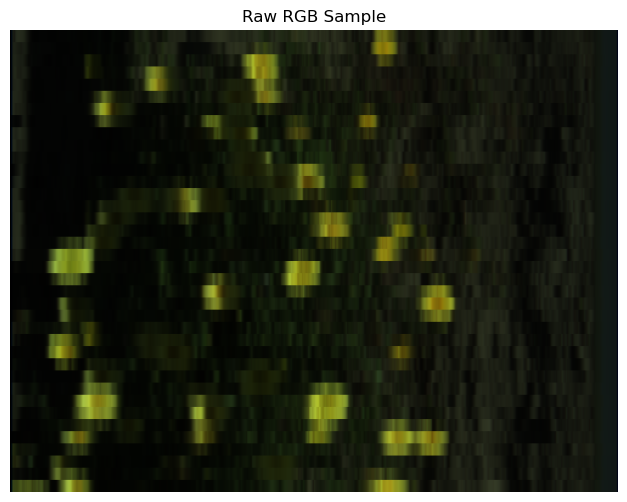

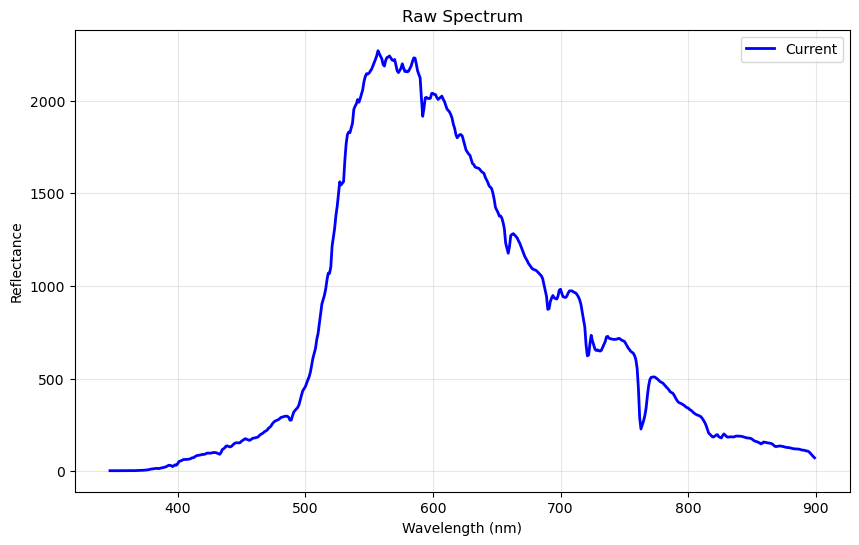

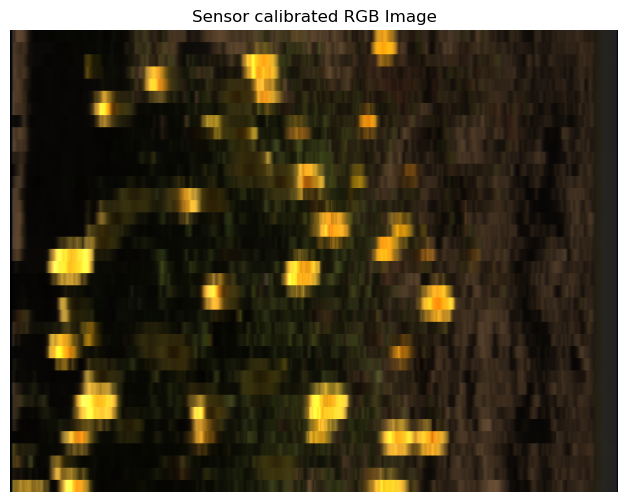

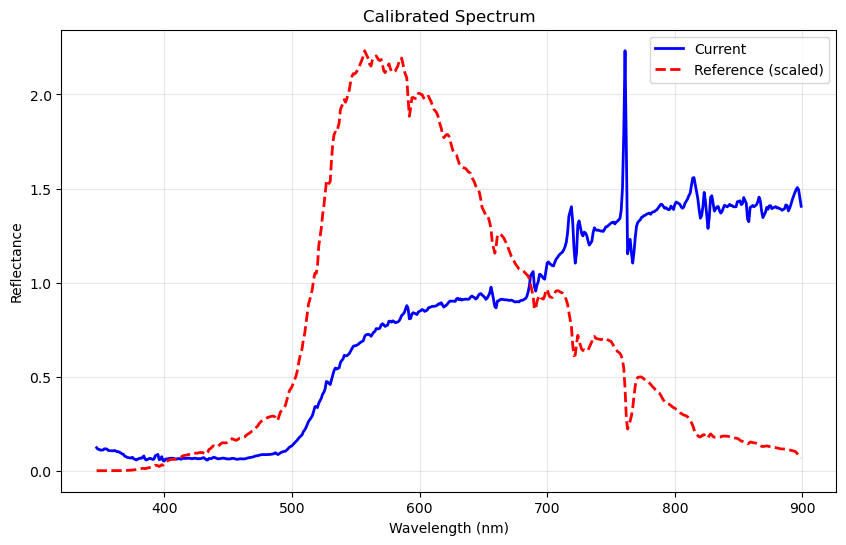

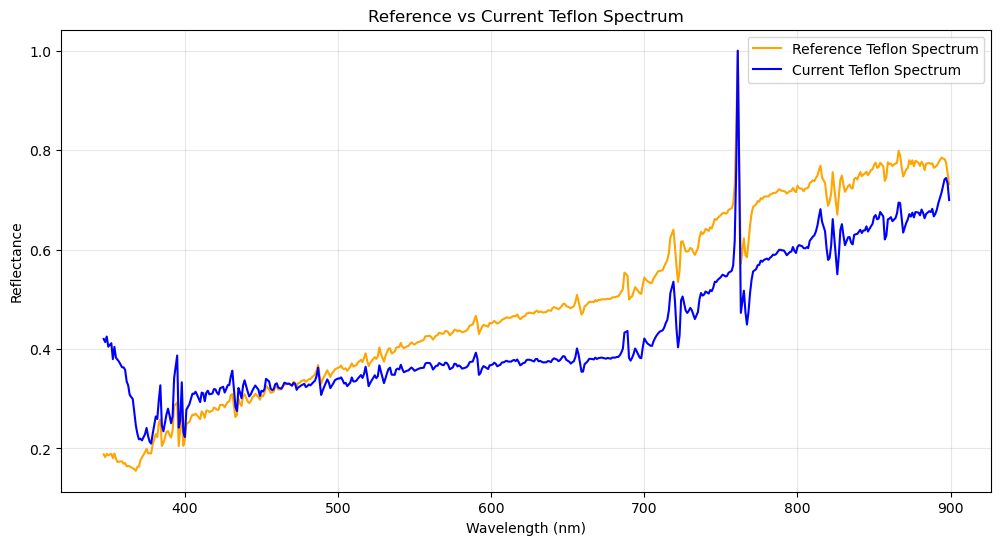

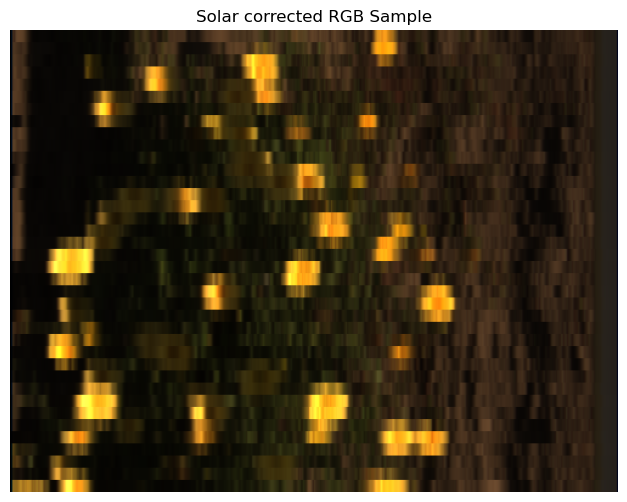

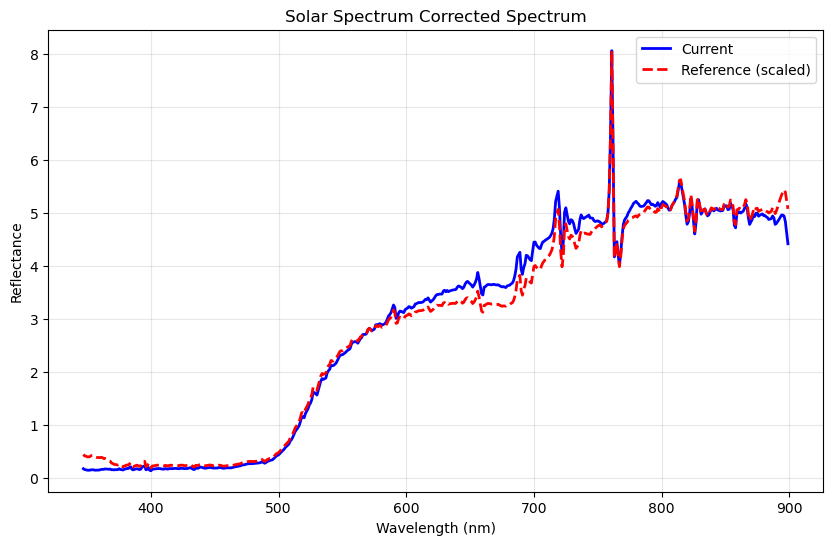

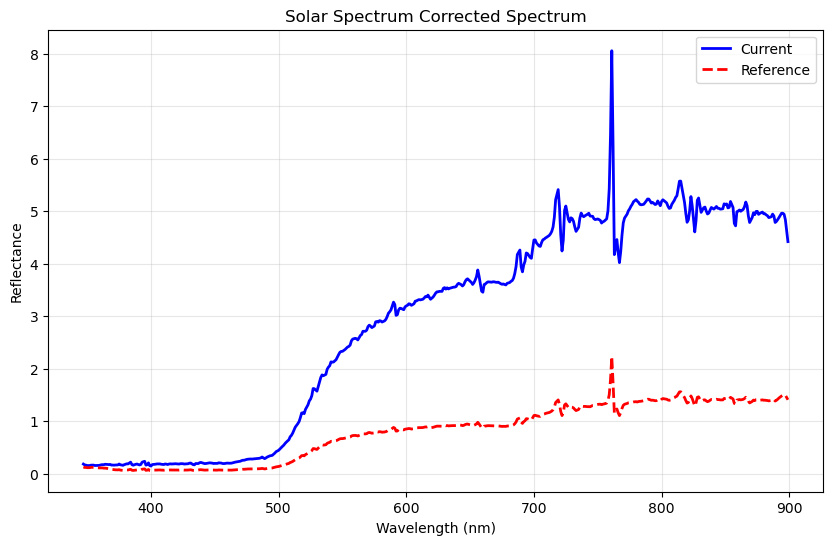

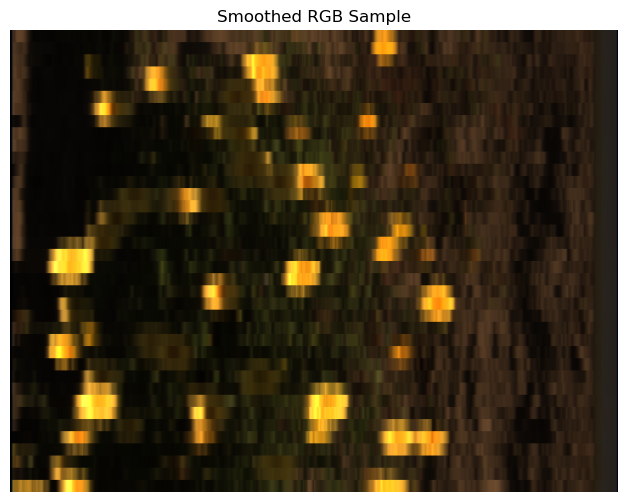

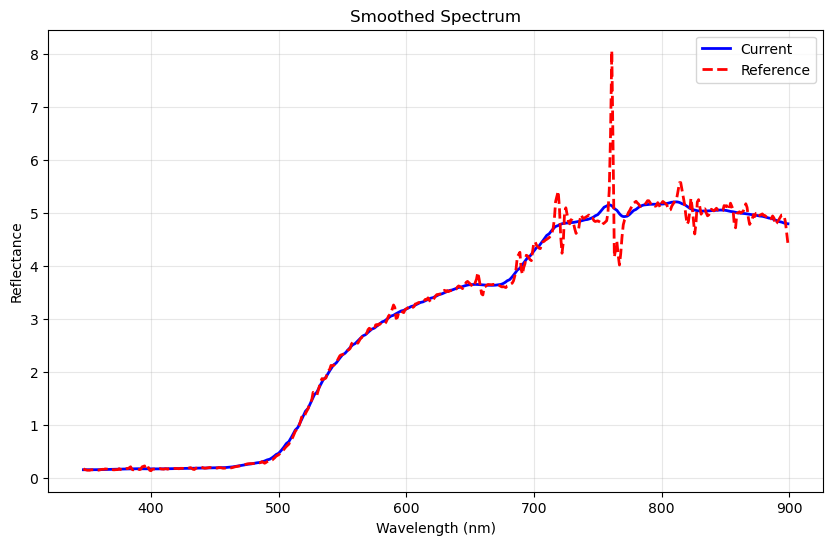

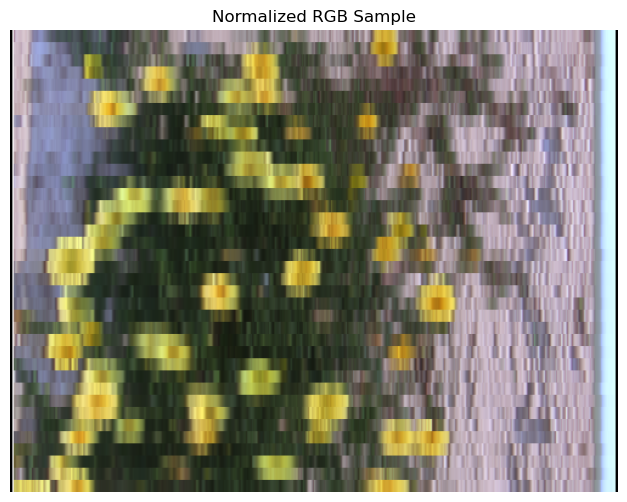

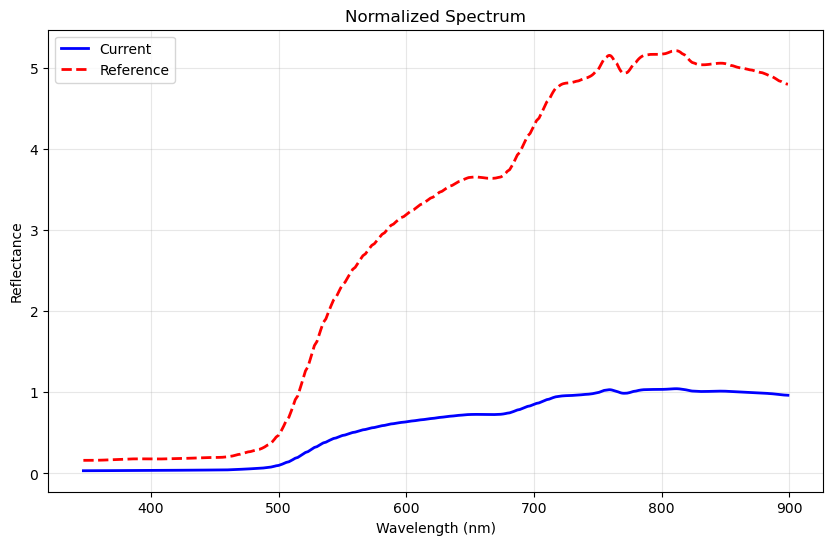

In [3]:
#  single image run
directory_path = r"data/workshop_data"
hs_image_path = r"data/workshop_data/2-7-L15-1-VNIR-Data.hdr"
hs_image_path2 = r"data/workshop_data/2-26-L26-1-VNIR-Data.hdr"
wc_path = r"data/Teflon na slunci/1-9-TestTray14-VNIR-WhiteCalibration.hdr"

# creating our preprocessor object:
preprocessor = HS_preprocessor(verbose=False)

# Loading raw image:
preprocessor.load_image(hs_image_path)

# visualizing raw image and spectra
raw_rgb = preprocessor.get_rgb_sample(normalize=False, correct=False, show=True, title="Raw RGB Sample", repeat=10)
raw_spec_1 = preprocessor.get_spectrum(roi=(slice(2, 5), slice(200, 220), slice(None)), title="Raw Spectrum", scale=False)


# Sensor Calibration
preprocessor.sensor_calibration(white_ref_path=wc_path, clip_to=10)
rgb_calibrated_1 = preprocessor.get_rgb_sample(normalize=False, correct=False, repeat=10, show=True, title="Sensor calibrated RGB Image")
# visualizing calibrated spectrum
calibrated_spec_1 = preprocessor.get_spectrum(roi=(slice(2, 5), slice(200, 220), slice(None)), ref_spectrum=raw_spec_1[0], title="Calibrated Spectrum", scale=True)


# Solar Spectrum Correction
## extracting ref teflon spectrum

ref_teflon = preprocessor.create_reference_teflon_library(hs_images=directory_path, white_ref_path=wc_path, teflon_edge_coord=(-10, -3))

# visualizing reference teflon spectrum and current image teflon spectrum
plt.figure(figsize=(12, 6))
plt.plot(preprocessor.image.ind, ref_teflon/np.max(ref_teflon), label='Reference Teflon Spectrum', color='orange')
plt.plot(preprocessor.image.ind, preprocessor.image.img[:, -10:-3, :].mean(axis=(0, 1))/ np.max(preprocessor.image.img[:, -10:-3, :].mean(axis=(0, 1))), label='Current Teflon Spectrum', color='blue')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance')
plt.title('Reference vs Current Teflon Spectrum')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Applying solar spectrum correction
preprocessor.solar_correction(teflon_edge_coord=(-10, -3), reference_teflon=ref_teflon, smooth_window=35)
rgb_solar_corrected = preprocessor.get_rgb_sample(normalize=False, correct=False,show=True, title="Solar corrected RGB Sample", repeat=10)
# visualizing solar corrected spectrum
solar_corrected_spec_1 = preprocessor.get_spectrum(roi=(slice(2, 5), slice(200, 220), slice(None)), ref_spectrum=calibrated_spec_1[0], title="Solar Spectrum Corrected Spectrum", scale=True)
solar_corrected_spec_1 = preprocessor.get_spectrum(roi=(slice(2, 5), slice(200, 220), slice(None)), ref_spectrum=calibrated_spec_1[0], title="Solar Spectrum Corrected Spectrum", scale=False)

# Spectral Smoothing
preprocessor.spectral_smoothing(sigma=6, mode='reflect')
rgb_smoothed = preprocessor.get_rgb_sample(normalize=False, correct=False, show=True, title="Smoothed RGB Sample", repeat=10)
# visualizing smoothed spectrum
smoothed_spec_1 = preprocessor.get_spectrum(roi=(slice(2, 5), slice(200, 220), slice(None)), ref_spectrum=solar_corrected_spec_1[0], title="Smoothed Spectrum", scale=False)

# Normalization
preprocessor.normalization(method='to_wl', to_wl=751, clip_to=10)
rgb_normalized = preprocessor.get_rgb_sample(normalize=True, correct=False, show=True, title="Normalized RGB Sample", repeat=10)
# visualizing normalized spectrum
normalized_spec_1 = preprocessor.get_spectrum(roi=(slice(2, 5), slice(200, 220), slice(None)), ref_spectrum=smoothed_spec_1[0], title="Normalized Spectrum", scale=False)

# Saving config into file
preprocessor.save_config("2025.08.15_preprocessor_config.json")

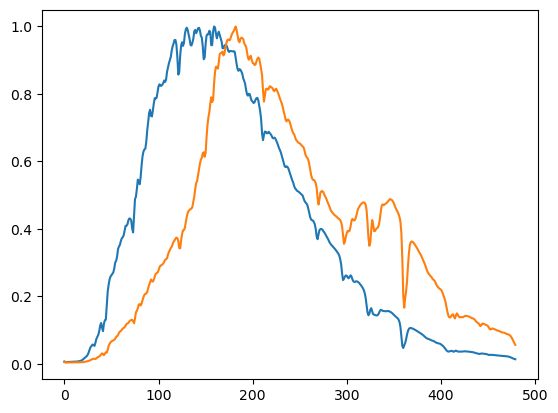

In [4]:
white_calibration = HS_image(r'/home/lamewarden/PSI/Code/2025_EPPS_Bonn/EPPS2025_workshop/data/Teflon na slunci/1-9-TestTray14-VNIR-WhiteCalibration.hdr')
white_matrix = np.mean(white_calibration.img, axis=(0,1))
img1 = HS_image(hs_image_path)
plt.plot(white_matrix/np.max(white_matrix))
plt.plot(np.mean(img1.img, axis=(0,1)) / np.max(np.mean(img1.img, axis=(0,1)) ))
plt.show()

## Retrieving pipeline parameters from a file and applying them to the whole folder

# Segmentation of VI
## One image run

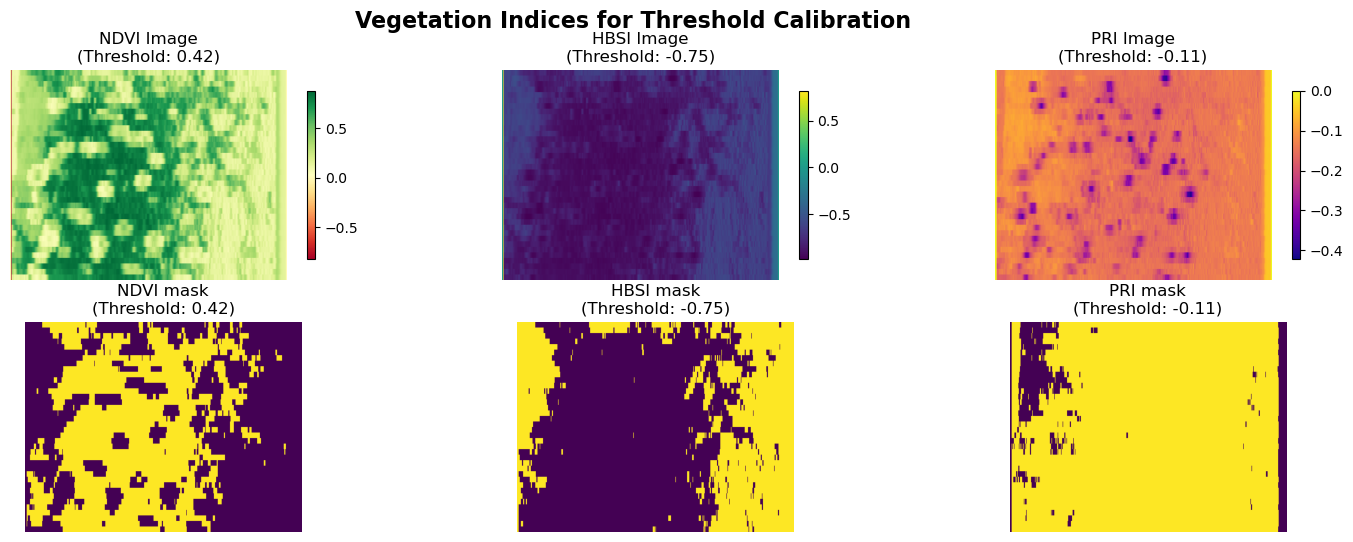

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..3.405612068644314].


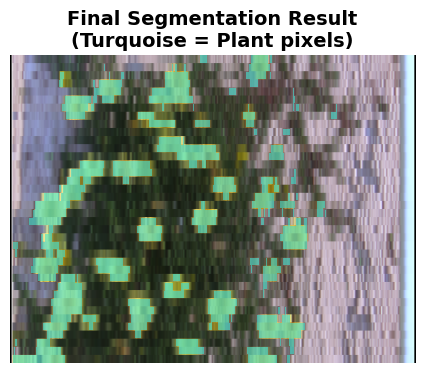

In [5]:
preprocessor.extract_masks(pri_thr=-0.11, ndvi_thr=0.42, hbsi_thr=-0.75, min_pix_size=10)

### Saving config to a file


In [6]:
preprocessor.save_config(r"./config/2025.08.15_config.json")

### Applying tested config to a separate image

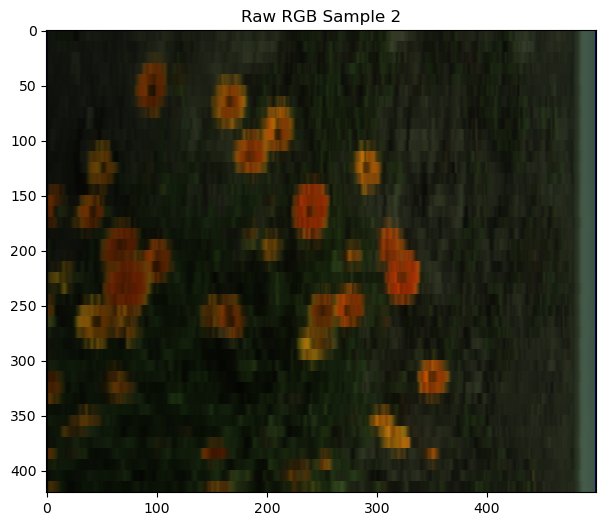

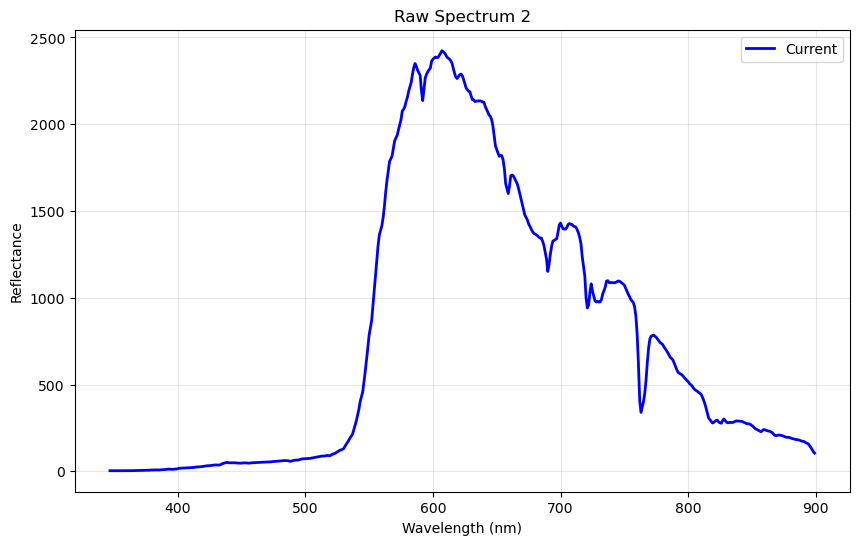

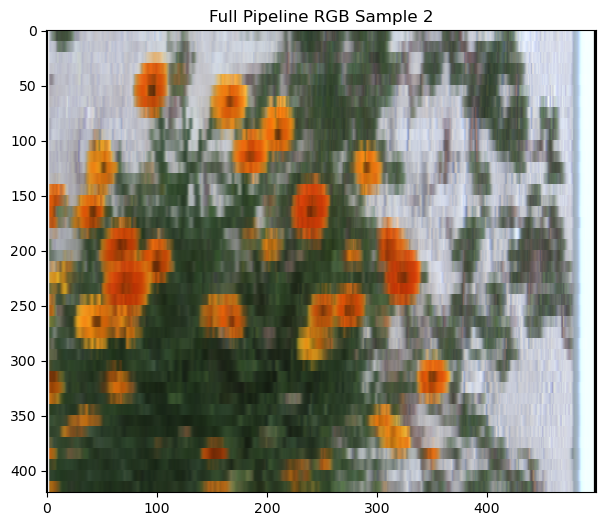

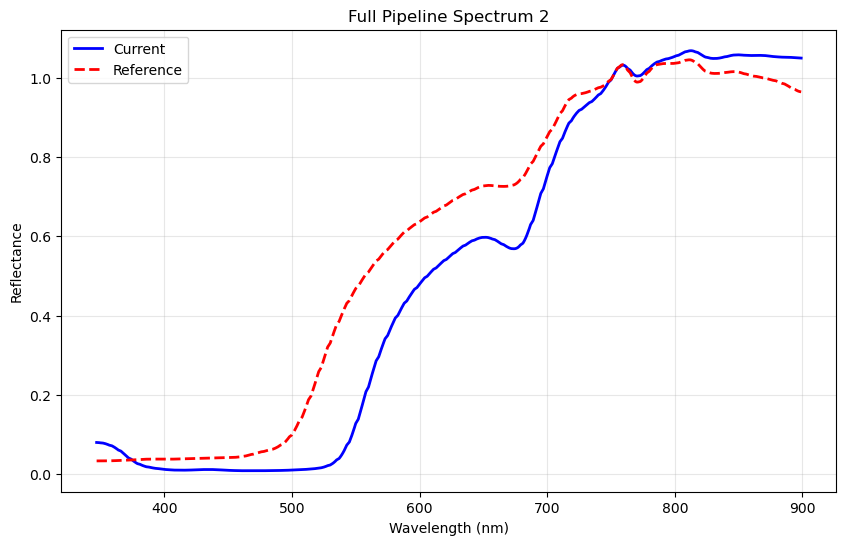

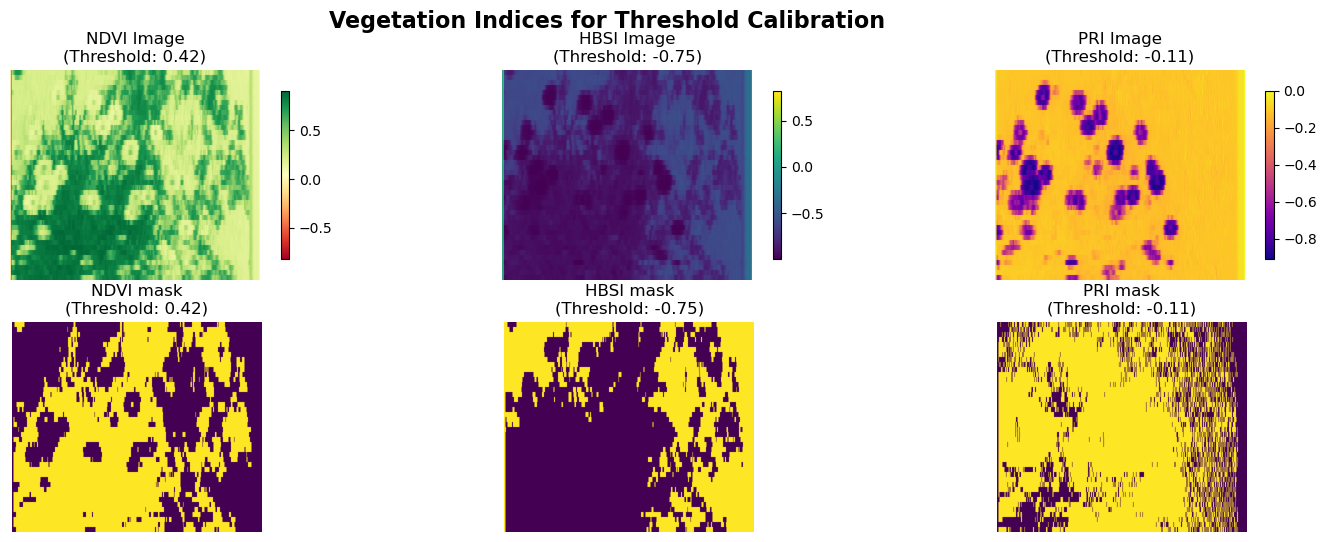

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..3.6053196644980403].


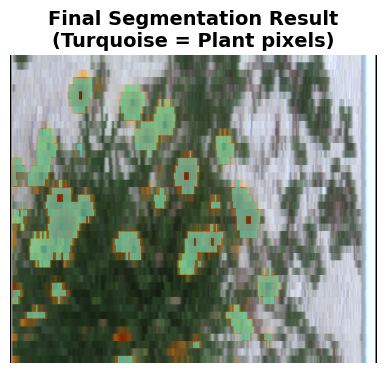

In [7]:
# creating new preprocessor object for second image
preprocessor_2 = HS_preprocessor(verbose=False)
# Loading second raw image:
preprocessor_2.load_image(hs_image_path2)
# showing raw RGB and spectrum
raw_rgb_2 = preprocessor_2.get_rgb_sample(normalize=False, correct=False, show=True, title="Raw RGB Sample 2", repeat=10, axes=True)
raw_spec_2 = preprocessor_2.get_spectrum(roi=(slice(21, 24), slice(315, 330), slice(None)), title="Raw Spectrum 2", scale=False)
# Loading saved config of a first preprocessing pipeline:
preprocessor_2.load_config(r"./config/2025.08.15_config.json")
# Running full pipeline on second image
preprocessor_2.run_full_pipeline()
# showing RGB and spectrum after full pipeline  
rgb_full_pipeline_2 = preprocessor_2.get_rgb_sample(normalize=True, correct=False, show=True, title="Full Pipeline RGB Sample 2", repeat=10, axes=True)
full_pipeline_spec_2 = preprocessor_2.get_spectrum(roi=(slice(21, 24), slice(315, 330), slice(None)), ref_spectrum=normalized_spec_1[0], title="Full Pipeline Spectrum 2", scale=False)

# extracting masks with preselected parameters
preprocessor_2.extract_masks()


### Loading the whole folder and applying loaded config

In [8]:
# Load config from file - everything is included in the config!
processed_images = HS_preprocessor.process_folder(
    folder_path=directory_path,
    config_path="config/2025.08.15_config.json",
    verbose=False
)

# Segmentation with VIs

### Mask parameters adjustment

## Extracting masked pixels and packing them into a dataframe

In [9]:
# converting processed images to DataFrame
extracted_spectra_df = HS_preprocessor.extract_masked_spectra_to_df(processed_images, save_path="data/extracted_spectra.csv")

Extracted 2265 masked pixels from 2-26-L25-2-VNIR-Data.hdr
Extracted 993 masked pixels from 2-28-L26-2-VNIR-Data.hdr
Extracted 1648 masked pixels from 2-24-L4-1-VNIR-Data.hdr
Extracted 3222 masked pixels from 2-7-L15-1-VNIR-Data.hdr
Extracted 629 masked pixels from 2-26-L25-1-VNIR-Data.hdr
Extracted 2583 masked pixels from 2-26-L26-1-VNIR-Data.hdr
Extracted 740 masked pixels from 2-26-L25-3-VNIR-Data.hdr
Extracted 3017 masked pixels from 2-20-L15-2-VNIR-Data.hdr
Extracted 2841 masked pixels from 2-20-L15-1-VNIR-Data.hdr
Extracted 1863 masked pixels from 2-24-L4-2-VNIR-Data.hdr
Extracted 1097 masked pixels from 2-28-L26-3-VNIR-Data.hdr
Extracted 1834 masked pixels from 2-24-L4-3-VNIR-Data.hdr
DataFrame saved to: data/extracted_spectra.csv


In [10]:
extracted_spectra_df.groupby('label').mean()

,347,348,349,350,352,353,354,355,356,357,...,889,890,891,892,894,895,896,897,898,899
label,,,,,,,,,,,,,,,,,,,,,
L15,0.080834,0.080755,0.080603,0.080387,0.080121,0.079818,0.079488,0.079136,0.078764,0.078362,...,1.096482,1.094383,1.092212,1.090022,1.087881,1.085877,1.084108,1.082671,1.081657,1.081132
L25,0.151216,0.150962,0.150457,0.149703,0.148707,0.147471,0.146001,0.144298,0.142361,0.140188,...,1.139983,1.139374,1.138607,1.137710,1.136730,1.135732,1.134796,1.134002,1.133425,1.133121
L26,0.147952,0.147673,0.147115,0.146278,0.145162,0.143764,0.142080,0.140103,0.137824,0.135230,...,1.123814,1.122911,1.121828,1.120597,1.119280,1.117957,1.116725,1.115688,1.114937,1.114542
L4,0.146787,0.146489,0.145888,0.144976,0.143742,0.142173,0.140255,0.137976,0.135326,0.132300,...,1.126991,1.125658,1.124127,1.122450,1.120708,1.119002,1.117446,1.116154,1.115229,1.114745


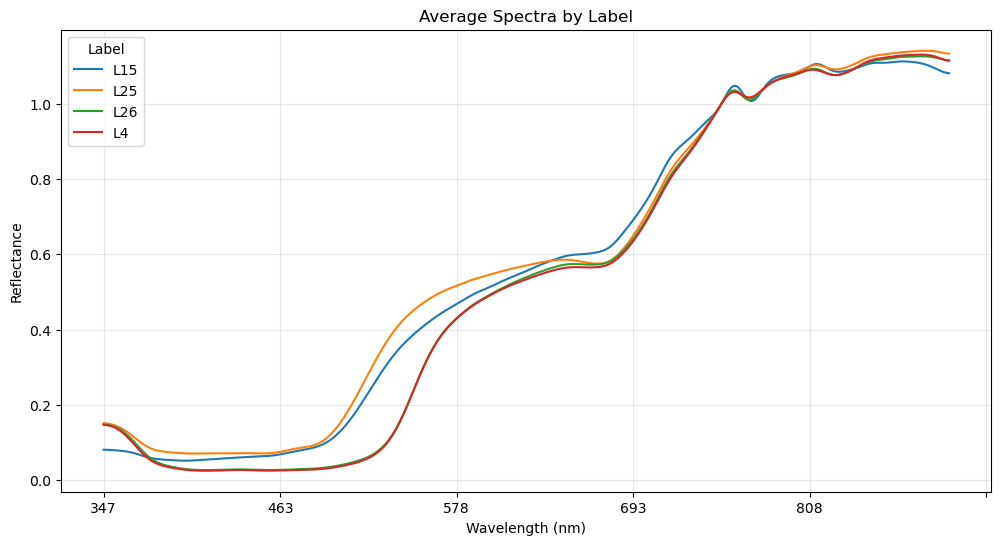

In [11]:
extracted_spectra_df.groupby('label').mean().T.plot(figsize=(12, 6))
plt.title('Average Spectra by Label')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance')
plt.grid(True, alpha=0.3)
plt.legend(title='Label')
plt.show()

# ML (will go into separate notebook)

In [12]:
from sklearn.metrics import (accuracy_score, recall_score, precision_score,
                             f1_score, cohen_kappa_score, classification_report,
                             confusion_matrix)
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timezone
import os
import datetime
import json


def upsample_data(X, y, method='random', random_state=42):
    """
    Upsample training data.
    
    Parameters
    ----------
    X : array-like of shape (n_samples, n_features)
        Feature matrix.
    y : array-like of shape (n_samples,)
        Labels/targets.
    method : str, optional (default='random')
        Method to use for upsampling. Options:
            - 'random': Random oversampling to match the largest class size.
            - 'smote': SMOTE oversampling.
    random_state : int, optional (default=42)
        Random seed for reproducibility.
        
    Returns
    -------
    X_resampled : ndarray of shape (n_samples_new, n_features)
        Upsampled feature matrix.
    y_resampled : ndarray of shape (n_samples_new,)
        Upsampled labels.
    """
    if method == 'random':
        # Convert to DataFrame for easy groupby/concat operations
        df_features = pd.DataFrame(X)
        df_labels = pd.Series(y, name='label')
        df_train = pd.concat([df_features, df_labels], axis=1)

        # Determine the max class size
        max_class_size = df_train['label'].value_counts().max()

        # Oversample each class to match max_class_size
        df_upsampled = pd.concat([
            resample(df_class,
                     replace=True,
                     n_samples=max_class_size,
                     random_state=random_state)
            for _, df_class in df_train.groupby('label')
        ])

        # Shuffle the upsampled data
        df_upsampled = df_upsampled.sample(frac=1, random_state=random_state)

        # Split back into X and y
        X_resampled = df_upsampled.drop('label', axis=1).values
        y_resampled = df_upsampled['label'].values
    
    elif method == 'smote':
        sm = SMOTE(random_state=random_state)
        X_resampled, y_resampled = sm.fit_resample(X, y)
    
    else:
        raise ValueError(f"Unsupported upsampling method: {method}. Use 'random' or 'smote'.")
    
    return X_resampled, y_resampled

def evaluate_and_store_metrics(y_test, y_pred, model_name, metrics_dict=None):
    """
    Calculates classification metrics, prints a classification report,
    and updates (or creates) a metrics dictionary.

    Args:
        y_test: True labels.
        y_pred: Predicted labels.
        model_name: Name of the model (used as key in metrics_dict).
        metrics_dict: (Optional) Existing metrics dictionary.  If None,
                      a new one is created.

    Returns:
        Updated metrics_dict.
    """

    if metrics_dict is None:
        metrics_dict = {}

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    kappa = cohen_kappa_score(y_test, y_pred)

    # Print metrics
    print(f'{model_name} Classification Accuracy: {accuracy:.4f}')
    print(f'{model_name} Recall: {recall:.4f}')
    print(f'{model_name} Precision: {precision:.4f}')
    print(f'{model_name} F1-score (weighted): {f1:.4f}')
    print(f'{model_name} Cohen\'s Kappa: {kappa:.4f}')
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # Calculate per-class accuracy
    cm = confusion_matrix(y_test, y_pred)
    per_class_accuracy = {}
    class_names = np.unique(y_test)  # Get unique class names
    for i in range(cm.shape[0]):
         # Ensure no division by zero
        if np.sum(cm[i, :]) > 0:
           per_class_accuracy[str(class_names[i])] = cm[i, i] / np.sum(cm[i, :])
        else:
            per_class_accuracy[str(class_names[i])] = 0.0 # Or np.nan, or another suitable placeholder

    # Store metrics in the dictionary
    metrics_dict[model_name] = {
        'Accuracy': accuracy,
        'F1-score': f1,
        'Recall': recall,
        'Precision': precision,
        'Kappa': kappa,
        'Per-class Accuracy': per_class_accuracy,
        'y_test': y_test,
        'y_pred': y_pred
    }

    return metrics_dict

def upsample_data(X, y, method='random', random_state=42):
    """
    Upsample training data.
    
    Parameters
    ----------
    X : array-like of shape (n_samples, n_features)
        Feature matrix.
    y : array-like of shape (n_samples,)
        Labels/targets.
    method : str, optional (default='random')
        Method to use for upsampling. Options:
            - 'random': Random oversampling to match the largest class size.
            - 'smote': SMOTE oversampling.
    random_state : int, optional (default=42)
        Random seed for reproducibility.
        
    Returns
    -------
    X_resampled : ndarray of shape (n_samples_new, n_features)
        Upsampled feature matrix.
    y_resampled : ndarray of shape (n_samples_new,)
        Upsampled labels.
    """
    if method == 'random':
        # Convert to DataFrame for easy groupby/concat operations
        df_features = pd.DataFrame(X)
        df_labels = pd.Series(y, name='label')
        df_train = pd.concat([df_features, df_labels], axis=1)

        # Determine the max class size
        max_class_size = df_train['label'].value_counts().max()

        # Oversample each class to match max_class_size
        df_upsampled = pd.concat([
            resample(df_class,
                     replace=True,
                     n_samples=max_class_size,
                     random_state=random_state)
            for _, df_class in df_train.groupby('label')
        ])

        # Shuffle the upsampled data
        df_upsampled = df_upsampled.sample(frac=1, random_state=random_state)

        # Split back into X and y
        X_resampled = df_upsampled.drop('label', axis=1).values
        y_resampled = df_upsampled['label'].values
    
    elif method == 'smote':
        sm = SMOTE(random_state=random_state)
        X_resampled, y_resampled = sm.fit_resample(X, y)
    
    else:
        raise ValueError(f"Unsupported upsampling method: {method}. Use 'random' or 'smote'.")
    
    return X_resampled, y_resampled


def compute_classification_metrics(y_true, y_pred, average='weighted'):
    """
    Compute classification metrics (accuracy, precision, recall, f1).
    
    Args:
        y_true (array-like): Ground truth labels.
        y_pred (array-like): Predicted labels.
        average (str, optional): Averaging method for multi-class
                                 precision, recall, f1. Defaults to 'weighted'.

    Returns:
        dict: A dictionary containing accuracy, precision, recall, and f1.
    """
    # Convert to numpy arrays if not already
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    accuracy_val = round(accuracy_score(y_true, y_pred),4)
    precision_val = round(precision_score(y_true, y_pred, average=average),4)
    recall_val = round(recall_score(y_true, y_pred, average=average),4)
    f1_val = round(f1_score(y_true, y_pred, average=average),4)
    
    return {
        'accuracy': accuracy_val,
        'precision': precision_val,
        'recall': recall_val,
        'f1': f1_val
    }

def plot_confusion_matrix(y_true, y_pred, class_names=None, fig_size=(8,6)):
    """
    Plot a confusion matrix with absolute counts and row-wise percentages.
    The percentage values are displayed in a smaller font.
    
    Args:
        y_true (array-like): Ground truth labels.
        y_pred (array-like): Predicted labels.
        class_names (list, optional): List of class names (strings).
            If None, indices [0..n_classes-1] will be used.
        fig_size (tuple, optional): Figure size in inches. Default is (8, 6).
    """
    cm = confusion_matrix(y_true, y_pred)
    n_classes = cm.shape[0]

    # If no class names are provided, just use numeric class indices
    if class_names is None:
        class_names = [str(i) for i in range(n_classes)]
    
    # Compute row-wise percentages
    cm_percent = np.zeros_like(cm, dtype=float)
    for i in range(n_classes):
        row_sum = cm[i].sum()
        if row_sum != 0:
            cm_percent[i] = cm[i] / row_sum * 100
        else:
            cm_percent[i] = 0

    fig, ax = plt.subplots(figsize=fig_size)
    cax = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar(cax)

    # Set tick marks and labels
    ax.set_xticks(np.arange(n_classes))
    ax.set_yticks(np.arange(n_classes))
    ax.set_xticklabels(class_names, rotation=45, ha='right')
    ax.set_yticklabels(class_names)

    # Determine threshold for text color
    threshold = cm.max() / 2.

    # Loop over data dimensions and create text annotations.
    for i in range(n_classes):
        for j in range(n_classes):
            abs_val = cm[i, j]
            perc_val = cm_percent[i, j]
            color = 'white' if abs_val > threshold else 'black'
            # Place absolute count above center
            ax.text(j, i - 0.2, f"{abs_val}", ha='center', va='center', color=color, fontsize=12)
            # Place percentage value below center in a smaller font
            ax.text(j, i + 0.2, f"{perc_val:.1f}%", ha='center', va='center', color=color, fontsize=8)

    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

def save_model(model, model_name, path, study=None):
    """
    Saves the given model to the specified path. The file name is prefixed with
    the current date (YYYY.MM.DD) and suffixed by `_model` or `_hp`.
    
    Parameters
    ----------
    model : scikit-learn estimator or torch.nn.Module
        The trained model to save.
    model_name : str
        A string identifying the model (e.g., "RandomForest", "ResNet").
    path : str
        The local directory where the model (and optional HP file) will be saved.
    study : optuna.study.Study, optional
        If provided, hyperparameters of the best trial will be saved as a JSON file.
    """
    # Lazy imports so the function doesn't break if the user does not have
    # both scikit-learn and PyTorch installed:
    try:
        import torch
    except ImportError:
        torch = None
    try:
        import joblib
    except ImportError:
        joblib = None

    # 1) Ensure directory exists
    os.makedirs(path, exist_ok=True)
    
    # 2) Create a date+name prefix for files
    date_str = datetime.now().strftime("%Y.%m.%d")
    base_file_name = f"{date_str}_{model_name}_model"
    
    # 3) Check if this is a PyTorch model or scikit-learn model
    if torch is not None and isinstance(model, torch.nn.Module):
        # Save as PyTorch .pth
        save_path = os.path.join(path, base_file_name + ".pth")
        torch.save(model.state_dict(), save_path)
    else:
        # Assume scikit-learn model; save as pickle
        if joblib is None:
            raise ImportError("joblib is required to save a scikit-learn model.")
        save_path = os.path.join(path, base_file_name + ".pkl")
        joblib.dump(model, save_path)

    print(f"Model saved to: {save_path}")

    # 4) If study is provided, save its best hyperparameters
    if study is not None:
        hp_file_name = base_file_name + "_hp.json"
        hp_path = os.path.join(path, hp_file_name)
        
        # Gather the best trial’s info
        hp_data = {
            "best_params": study.best_params,
            "best_value": study.best_value,
            "best_trial_number": study.best_trial.number
        }
        with open(hp_path, "w") as f:
            json.dump(hp_data, f, indent=4)

        print(f"Hyperparameters saved to: {hp_path}")

def vis_clust_2D(X, pc_to_visualize):
    fig, ax = plt.subplots(figsize=(10, 8))

    # Map unique labels to integer values to color them
    unique_labels = X['label'].unique()
    label_mapping = {label: i for i, label in enumerate(unique_labels)}
    colors = X['label'].map(label_mapping)

    # Create a scatter plot, color by 'label' column values
    scatter = ax.scatter(x=X.iloc[:, pc_to_visualize[0]], y=X.iloc[:, pc_to_visualize[1]], c=colors, cmap='rainbow')

    # Create a legend with the actual 'label' values
    handles, _ = scatter.legend_elements()
    labels = [str(label) for label in unique_labels]
    ax.legend(handles=handles, labels=labels, title="Label")
    plt.xlabel(f'PC{pc_to_visualize[0]}')
    plt.ylabel(f'PC{pc_to_visualize[1]}')

    # Show the plot
    plt.show()

In [13]:
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score
import optuna
from optuna.samplers import TPESampler
import numpy as np
from sklearn.model_selection import train_test_split


df = pd.read_csv(r'suppl_files\2025.06.02_filtered_df.csv')
# df = copy.deepcopy(filtered_df)
df.columns = df.columns.map(lambda x: int(x) if str(x).isdigit() else x)



# Prepare features and labels
X = df.loc[:,450:849].values
y = df['label'].values

# Split randomly instead
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3,  # Adjust test size as needed
    random_state=42, 
    stratify=y  # Ensures balanced distribution of labels in train/test
)


#  Upsampling (insert slide explaining that)
X_train, y_train = upsample_data(X_train, y_train, method='smote',random_state=42)


n_jobs = 12
# SMOTE Upsampling

# ============================
# 1) Define the objective for Optuna
# ============================
def objective(trial):
    # PCA hyperparameter
    n_components = trial.suggest_categorical('n_components', [10, 20, 30, 40])
    
    # RandomForest hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 50, 300, step=25)
    max_depth = trial.suggest_int('max_depth', 2, 10, step=2)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 5)

    # Build pipeline: PCA -> RF
    pipeline = Pipeline([
        ('pca', PCA(n_components=n_components)),
        ('rf', RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            random_state=42,
            n_jobs=n_jobs
        ))
    ])

    # Use 5-fold stratified cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='accuracy')
    return np.mean(scores)

# ============================
# 2) Run the Optuna study
# ============================
study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
study.optimize(objective, n_trials=40, show_progress_bar=True, n_jobs=n_jobs)  # Adjust n_trials as desired

print("Best trial:")
print(f"  Value (Accuracy): {study.best_value:.4f}")
print("  Params:")
for key, val in study.best_params.items():
    print(f"    {key}: {val}")

# ============================
# 3) Train final RF with best hyperparameters
# ============================
best_params = study.best_params
# Read the JSON file as a dictionary (if you want to use already trained pipline)
# with open(r'suppl_files\models\RF\2025.03.13_RF_PCA_class_model_hp.json', 'r') as file:
#     best_params = json.load(file)

pipeline = Pipeline([
        ('pca', PCA(n_components=study.best_params['n_components'])),
        ('rf', RandomForestClassifier(
            n_estimators=study.best_params['n_estimators'],
            max_depth=study.best_params['max_depth'],
            min_samples_split=study.best_params['min_samples_split'],
            min_samples_leaf=study.best_params['min_samples_leaf'],
            random_state=42,
            n_jobs=n_jobs
        ))
    ])


# ============================
# 4) Evaluate on X_val, y_val
# ============================
metrics_dict = {}
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
# updating metrics of the model
metrics_dict = evaluate_and_store_metrics(y_test, y_pred, "RF_PCA", metrics_dict)
# If you have a confusion-matrix plotting function:
plot_confusion_matrix(y_test, y_pred, class_names=np.unique(y_test))
# saving model
save_model(pipeline, 'RF_PCA_class',r'suppl_files\models\2025.06\HSI\RF',study)


FileNotFoundError: [Errno 2] No such file or directory: 'suppl_files\\2025.06.02_filtered_df.csv'

# PCA Visualization and Feature Analysis

Now that we have trained the RF+PCA pipeline, let's analyze:
1. PCA scatter plot with labels colored by line names  
2. Hierarchical clustering to show which labels are similar
3. Feature importance analysis for wavelengths in the RF+PCA pipeline

In [ ]:
# Extract PCA components from the trained pipeline
pca_component = pipeline.named_steps['pca']
rf_component = pipeline.named_steps['rf']

# Transform data using the fitted PCA
X_pca = pca_component.transform(X)

print(f"Original data shape: {X.shape}")
print(f"PCA transformed shape: {X_pca.shape}")
print(f"Explained variance ratio (first 5 components): {pca_component.explained_variance_ratio_[:5]}")
print(f"Total explained variance: {pca_component.explained_variance_ratio_.sum():.3f}")

Original data shape: (22732, 347)
PCA transformed shape: (22732, 40)
Explained variance ratio (first 5 components): [0.65570629 0.25476356 0.04900397 0.02075769 0.01053024]
Total explained variance: 1.000


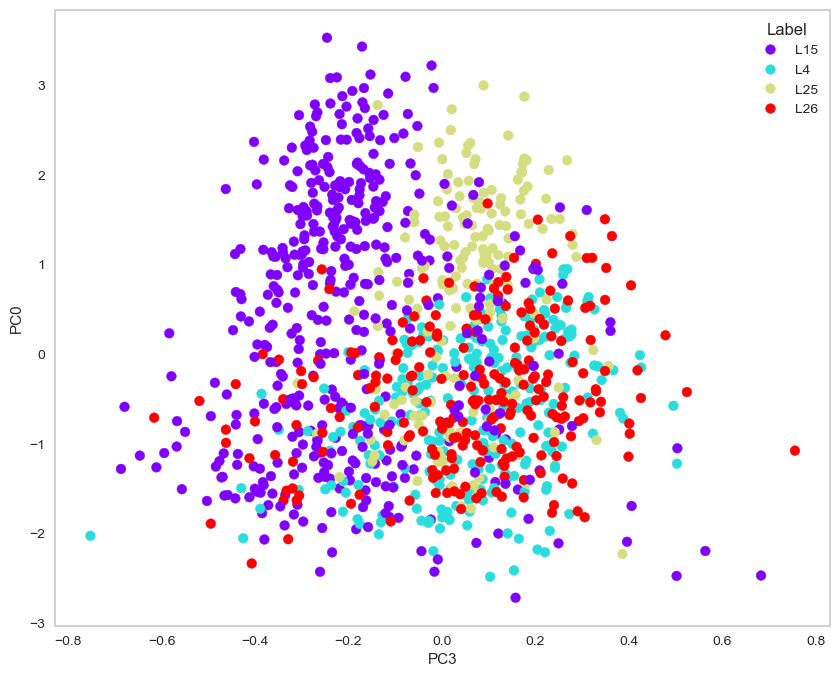

In [ ]:
# Create a DataFrame from X_pca with labels for visualization
X_pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])
X_pca_df['label'] = y

vis_clust_2D(X_pca_df.iloc[::20, :], pc_to_visualize=(3, 0))

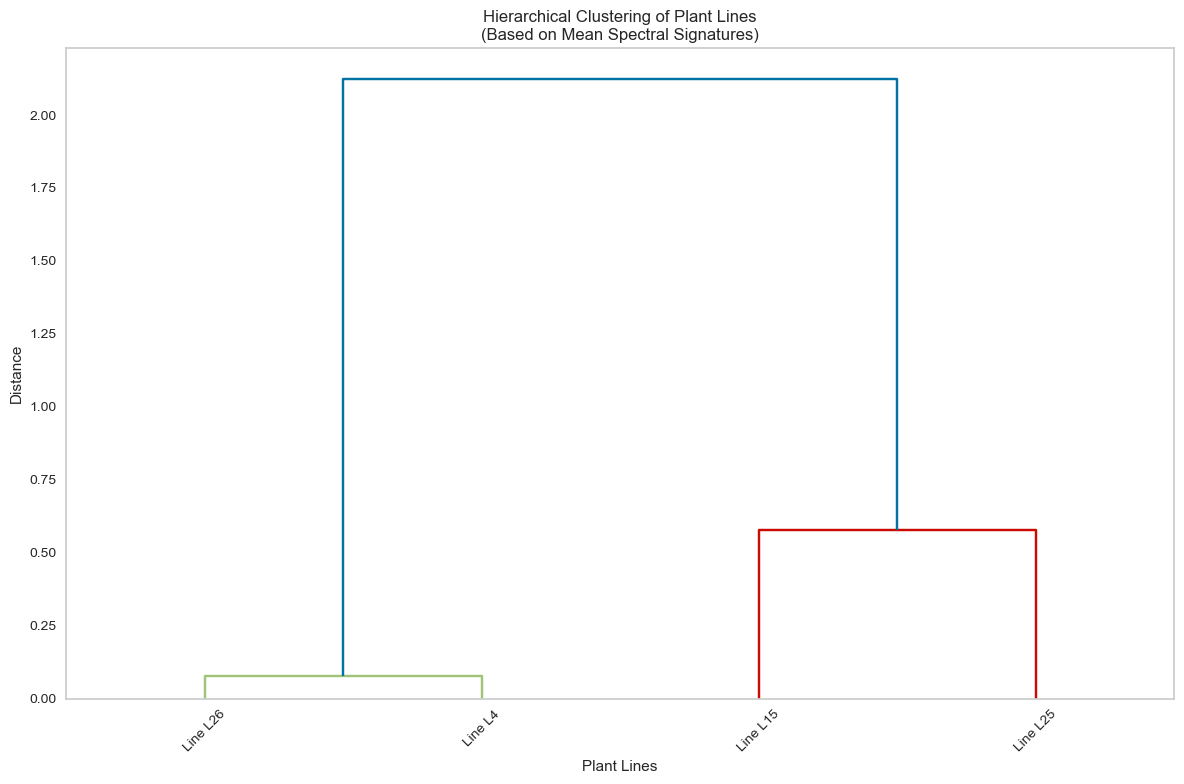

In [ ]:
# Hierarchical Clustering Analysis
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform

# Calculate mean spectra for each label
mean_spectra = []
label_names = []
for label in unique_labels:
    mask = y == label
    mean_spectrum = X[mask].mean(axis=0)
    mean_spectra.append(mean_spectrum)
    label_names.append(f'Line {label}')

mean_spectra = np.array(mean_spectra)

# Calculate distance matrix between mean spectra
distances = pdist(mean_spectra, metric='euclidean')
linkage_matrix = linkage(distances, method='ward')

# Create dendrogram
plt.figure(figsize=(12, 8))
dendrogram(linkage_matrix, labels=label_names, leaf_rotation=45, leaf_font_size=10)
plt.title('Hierarchical Clustering of Plant Lines\n(Based on Mean Spectral Signatures)')
plt.xlabel('Plant Lines')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()



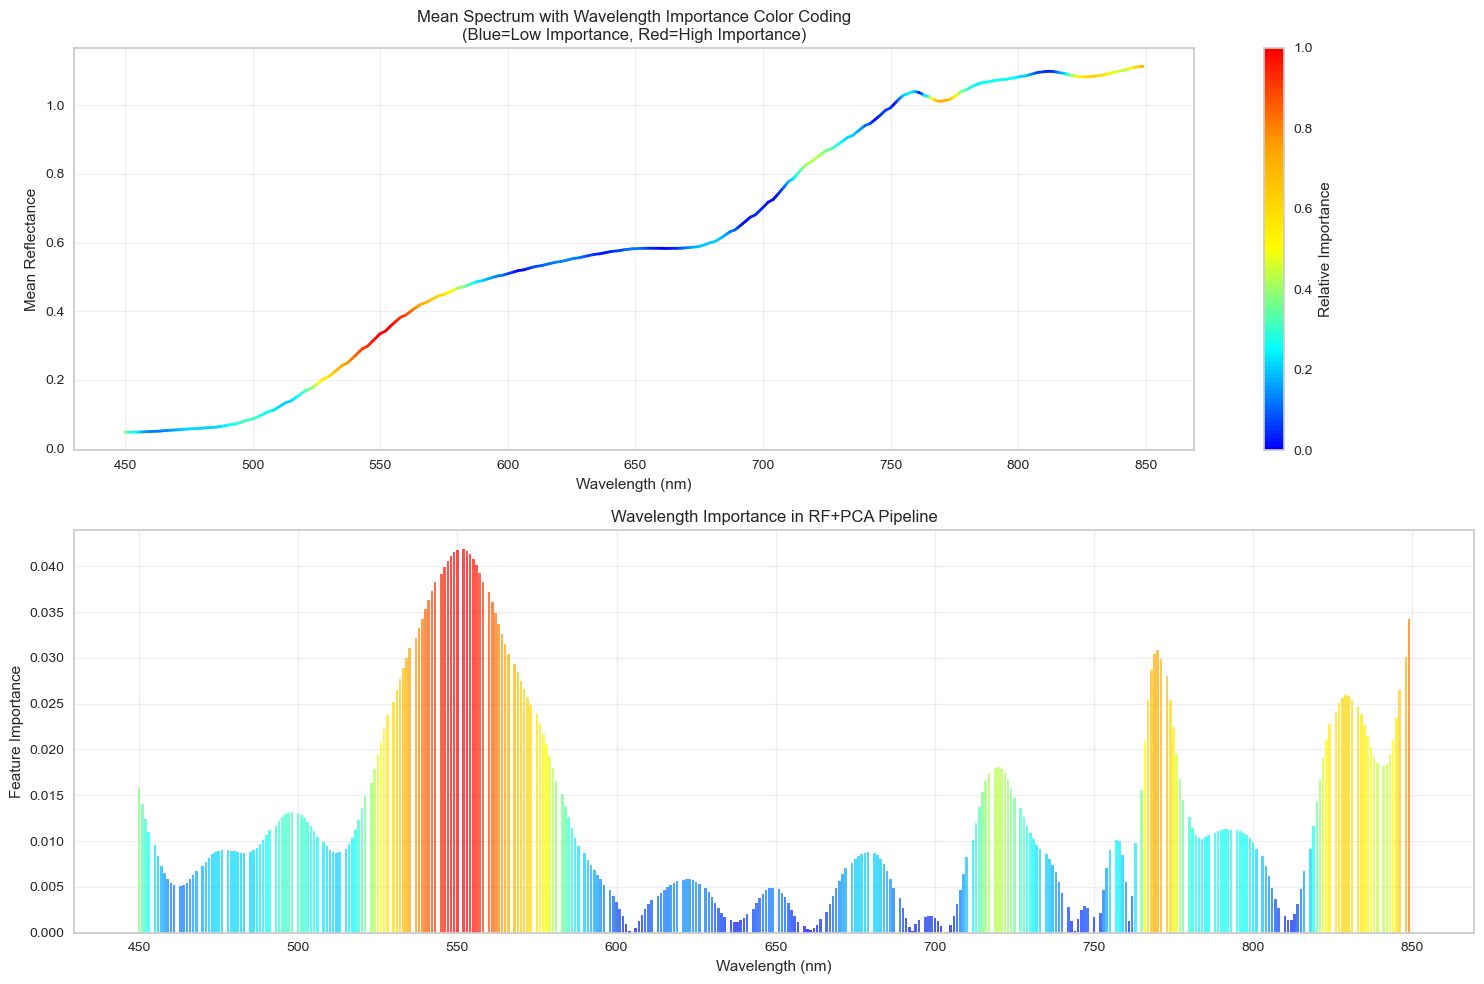


Top 10 most important wavelengths:
 1.  552 nm - Importance: 0.0418
 2.  550 nm - Importance: 0.0418
 3.  553 nm - Importance: 0.0417
 4.  549 nm - Importance: 0.0416
 5.  554 nm - Importance: 0.0413
 6.  548 nm - Importance: 0.0412
 7.  555 nm - Importance: 0.0408
 8.  547 nm - Importance: 0.0406
 9.  556 nm - Importance: 0.0401
10.  546 nm - Importance: 0.0399

PCA Components shape: (40, 347)
RF Feature Importance shape: (40,)
Wavelength Importance shape: (347,)
Number of wavelengths: 347


In [ ]:
# Feature Importance Analysis for Wavelengths in RF+PCA Pipeline
from matplotlib.colors import LinearSegmentedColormap

# Get PCA components and RF feature importance
pca_components = pca_component.components_  # Shape: (n_components, n_features)
rf_feature_importance = rf_component.feature_importances_  # Shape: (n_components,)

# Calculate wavelength importance by combining PCA loadings with RF importance
# This gives us the contribution of each original wavelength to the final prediction
wavelength_importance = np.abs(pca_components.T @ rf_feature_importance)

# Normalize importance to 0-1 range for color mapping
wavelength_importance_norm = (wavelength_importance - wavelength_importance.min()) / (wavelength_importance.max() - wavelength_importance.min())

# Get wavelengths from the original data
wavelengths = df.columns[df.columns.map(lambda x: str(x).isdigit())].astype(int).values
wavelengths = wavelengths[(wavelengths >= 450) & (wavelengths <= 849)]

# Calculate mean spectrum across all samples for visualization
mean_spectrum = X.mean(axis=0)

# Create color map from blue (low importance) to red (high importance)
colors = ['blue', 'cyan', 'yellow', 'orange', 'red']
n_bins = 100
cmap = LinearSegmentedColormap.from_list('importance', colors, N=n_bins)

# Create the plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# Plot 1: Color-coded spectrum line
for i in range(len(wavelengths)-1):
    color = cmap(wavelength_importance_norm[i])
    ax1.plot(wavelengths[i:i+2], mean_spectrum[i:i+2], color=color, linewidth=2)

ax1.set_xlabel('Wavelength (nm)')
ax1.set_ylabel('Mean Reflectance')
ax1.set_title('Mean Spectrum with Wavelength Importance Color Coding\n(Blue=Low Importance, Red=High Importance)')
ax1.grid(True, alpha=0.3)

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax1)
cbar.set_label('Relative Importance')

# Plot 2: Importance values as bar plot
ax2.bar(wavelengths, wavelength_importance, color=[cmap(x) for x in wavelength_importance_norm], alpha=0.7)
ax2.set_xlabel('Wavelength (nm)')
ax2.set_ylabel('Feature Importance')
ax2.set_title('Wavelength Importance in RF+PCA Pipeline')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print top important wavelengths
top_n = 10
top_indices = np.argsort(wavelength_importance)[-top_n:][::-1]
print(f"\nTop {top_n} most important wavelengths:")
for i, idx in enumerate(top_indices):
    print(f"{i+1:2d}. {wavelengths[idx]:4d} nm - Importance: {wavelength_importance[idx]:.4f}")

print(f"\nPCA Components shape: {pca_components.shape}")
print(f"RF Feature Importance shape: {rf_feature_importance.shape}")
print(f"Wavelength Importance shape: {wavelength_importance.shape}")
print(f"Number of wavelengths: {len(wavelengths)}")

# Classification of Processed Images

Apply the trained RF+PCA pipeline to classify masked pixels in processed images and visualize results with colored overlays for each predicted class.

In [ ]:
def classify_processed_images(processed_images, masks, pipeline, repeat=10):
    """
    Classify masked pixels in processed images using trained pipeline.
    
    Parameters:
    -----------
    processed_images : dict
        Dictionary of processed HS images
    masks : dict 
        Dictionary of masks for each image
    pipeline : sklearn.Pipeline
        Trained classification pipeline
    repeat : int
        Repeat factor for visualization
        
    Returns:
    --------
    classification_results : dict
        Dictionary containing classification results for each image
    """
    
    # Get unique labels and assign colors
    unique_labels = np.unique(y_train)
    colors = plt.cm.Set3(np.linspace(0, 1, len(unique_labels)))
    label_colors = {label: colors[i] for i, label in enumerate(unique_labels)}
    
    print(f"Available labels: {unique_labels}")
    print(f"Color mapping: {label_colors}")
    
    classification_results = {}
    
    for image_name, hs_image in processed_images.items():
        print(f"\nProcessing {image_name}...")
        
        # Get corresponding mask
        if image_name in masks:
            mask = masks[image_name]
        else:
            print(f"No mask found for {image_name}, skipping...")
            continue
            
        # Get image data and reshape
        img_data = hs_image.img  # Shape: (height, width, bands)
        height, width, n_bands = img_data.shape
        
        # Create mask for valid pixels (where mask == 1)
        if len(mask.shape) == 3:
            mask_2d = mask[:, :, 0]  # Convert to 2D if needed
        else:
            mask_2d = mask
            
        valid_pixels = mask_2d == 1
        n_valid_pixels = np.sum(valid_pixels)
        
        if n_valid_pixels == 0:
            print(f"No valid pixels in {image_name}")
            continue
            
        print(f"Found {n_valid_pixels} valid pixels to classify")
        
        # Extract spectra for masked pixels
        masked_spectra = img_data[valid_pixels]  # Shape: (n_valid_pixels, n_bands)
        
        # Filter to wavelength range used in training (350-849 nm)
        wavelength_mask = (np.array(hs_image.ind) >= 450) & (np.array(hs_image.ind) <= 849)
        masked_spectra_filtered = masked_spectra[:, wavelength_mask]
        
        print(f"Spectral data shape: {masked_spectra_filtered.shape}")
        
        # Predict using pipeline
        predictions = pipeline.predict(masked_spectra_filtered)
        prediction_probs = pipeline.predict_proba(masked_spectra_filtered)
        
        print(f"Predictions shape: {predictions.shape}")
        print(f"Unique predictions: {np.unique(predictions, return_counts=True)}")
        
        # Create classification map - use object dtype to handle string labels
        classification_map = np.full((height, width), '', dtype=object)
        classification_map[valid_pixels] = predictions
        
        # Create probability maps for each class
        prob_maps = {}
        for i, label in enumerate(unique_labels):
            prob_map = np.zeros((height, width))
            prob_map[valid_pixels] = prediction_probs[:, i]
            prob_maps[label] = prob_map
        
        # Store results
        classification_results[image_name] = {
            'classification_map': classification_map,
            'probability_maps': prob_maps,
            'predictions': predictions,
            'prediction_probs': prediction_probs,
            'valid_pixels': valid_pixels,
            'n_valid_pixels': n_valid_pixels
        }
        
        # Print basic statistics
        print(f"Classification Statistics for {image_name}:")
        for label in unique_labels:
            count = np.sum(classification_map == label)
            percentage = (count / np.sum(valid_pixels)) * 100 if np.sum(valid_pixels) > 0 else 0
            print(f"  Line {label}: {count:4d} pixels ({percentage:5.1f}%)")
        print()
    
    # Show simplified grid visualization at the end
    print("Creating classification overview...")
    visualize_classification_grid(classification_results, processed_images, label_colors, unique_labels, repeat)
    
    return classification_results, label_colors

# Run classification (uncomment if you want to run again)
# classification_results, label_colors = classify_processed_images(processed_images, masks, pipeline, repeat=10)

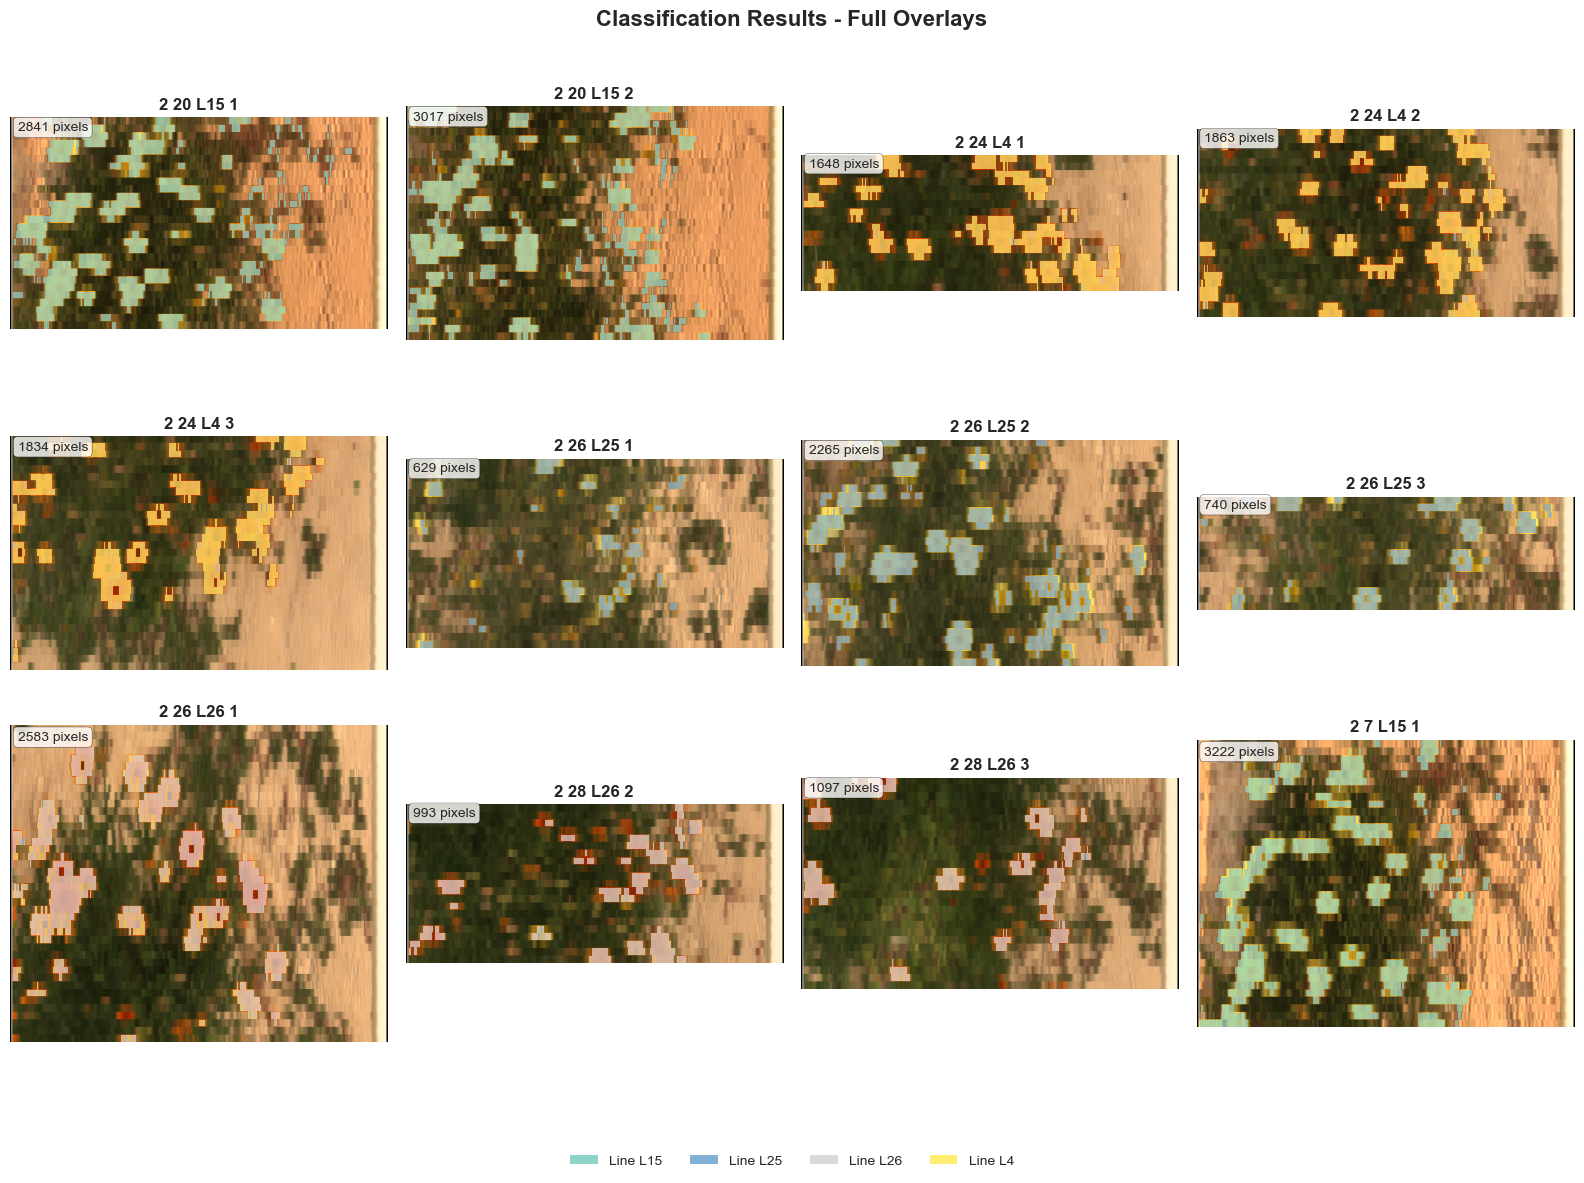


Classification Summary:
2-20-L15-1          : 2841 pixels,  99.9% L15
2-20-L15-2          : 3017 pixels,  99.9% L15
2-24-L4-1           : 1648 pixels,  96.7% L4
2-24-L4-2           : 1863 pixels,  96.3% L4
2-24-L4-3           : 1834 pixels,  95.1% L4
2-26-L25-1          :  629 pixels,  98.9% L25
2-26-L25-2          : 2265 pixels,  99.6% L25
2-26-L25-3          :  740 pixels,  99.1% L25
2-26-L26-1          : 2583 pixels,  84.6% L26
2-28-L26-2          :  993 pixels,  97.2% L26
2-28-L26-3          : 1097 pixels,  98.4% L26
2-7-L15-1           : 3222 pixels,  96.5% L15


In [ ]:
def visualize_classification_grid(classification_results, processed_images, label_colors, unique_labels, repeat=10):
    """
    Simplified visualization showing only full classification overlays in a grid.
    
    Parameters:
    -----------
    classification_results : dict
        Dictionary containing classification results for each image
    processed_images : dict
        Dictionary of processed HS images
    label_colors : dict
        Mapping of labels to colors
    unique_labels : numpy.ndarray
        Array of unique class labels
    repeat : int
        Repeat factor for visualization
    """
    
    n_images = len(classification_results)
    
    # Calculate grid dimensions (try to make it roughly square)
    cols = int(np.ceil(np.sqrt(n_images)))
    rows = int(np.ceil(n_images / cols))
    
    # Create figure
    fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
    fig.suptitle('Classification Results - Full Overlays', fontsize=16, fontweight='bold')
    
    # Handle single row or column case
    if rows == 1 and cols == 1:
        axes = [axes]
    elif rows == 1 or cols == 1:
        axes = axes.flatten()
    else:
        axes = axes.flatten()
    
    # Plot each image
    for idx, (image_name, results) in enumerate(classification_results.items()):
        if idx >= len(axes):
            break
            
        hs_image = processed_images[image_name]
        classification_map = results['classification_map']
        
        # Get RGB representation
        orig_rgb = get_rgb_sample(hs_image, normalize=False, correct=False) * 2
        orig_rgb = np.clip(orig_rgb, 0, 1)  # Clip to valid range
        
        # Repeat for visualization
        rgb_rep = np.repeat(orig_rgb, repeat, axis=0)
        classification_rep = np.repeat(classification_map, repeat, axis=0)
        
        # Show original image
        axes[idx].imshow(rgb_rep)
        
        # Create multi-class overlay
        full_overlay = np.full((classification_rep.shape[0], classification_rep.shape[1], 3), np.nan)
        for label in unique_labels:
            class_mask = classification_rep == label
            if np.any(class_mask):
                color = label_colors[label]
                full_overlay[class_mask, :] = color[:3]  # Use RGB components
        
        # Apply overlay
        axes[idx].imshow(full_overlay, alpha=0.7)
        
        # Clean up image name for title
        clean_name = image_name.replace('-VNIR-Data.hdr', '').replace('-', ' ')
        axes[idx].set_title(clean_name, fontsize=12, fontweight='bold')
        axes[idx].axis('off')
        
        # Add pixel count text
        total_pixels = np.sum(results['valid_pixels'])
        axes[idx].text(0.02, 0.98, f'{total_pixels} pixels', 
                      transform=axes[idx].transAxes, 
                      verticalalignment='top',
                      bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8),
                      fontsize=10)
    
    # Hide unused subplots
    for idx in range(len(classification_results), len(axes)):
        axes[idx].set_visible(False)
    
    # Create legend
    legend_elements = []
    for label in unique_labels:
        color = label_colors[label]
        legend_elements.append(plt.Rectangle((0,0),1,1, facecolor=color[:3], 
                                           label=f'Line {label}'))
    
    fig.legend(handles=legend_elements, loc='center', bbox_to_anchor=(0.5, 0.02), ncol=len(unique_labels))
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.1)
    plt.show()
    
    # Print summary statistics
    print("\nClassification Summary:")
    print("=" * 60)
    for image_name, results in classification_results.items():
        classification_map = results['classification_map']
        valid_pixels = results['valid_pixels']
        total_pixels = np.sum(valid_pixels)
        
        # Find dominant class
        unique_preds, counts = np.unique(classification_map[valid_pixels], return_counts=True)
        dominant_idx = np.argmax(counts)
        dominant_class = unique_preds[dominant_idx]
        dominant_percentage = (counts[dominant_idx] / total_pixels) * 100
        
        clean_name = image_name.replace('-VNIR-Data.hdr', '')
        print(f"{clean_name:20s}: {total_pixels:4d} pixels, {dominant_percentage:5.1f}% {dominant_class}")

# Run the simplified visualization
visualize_classification_grid(classification_results, processed_images, label_colors, unique_labels, repeat=10)